<a href="https://colab.research.google.com/github/r-ogrady/demos_vis_geospatial/blob/main/c28_train_speech_commandsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes
* **Purpose:** train Speech Commands with noise different alpha, layer type and lr
* Data preprocessed, Desired label = word, orthog label = noise type

In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import copy
import random
import gc
from google.colab import drive
import sys
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
# in colab - mount drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Dissertation/code'
sys.path.append("drive/My Drive/Dissertation/code")

Mounted at /content/drive/
/content/drive/My Drive/Dissertation/code


In [3]:
from b01_cpl import CorrelationPenaltyLoss
from b02_models import AlexNet
from b03_plotters import plotter0, plotter, plotter_corr

# Helper functions and initialisations
For training, plotting training metrics and checking accuracy on test set

In [4]:
# random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
generator1=torch.Generator().manual_seed(42)


In [5]:
# trainer with my loss
def trainer0(n_epochs,lrs,train_dataloader,val_dataloader):

    # storage
    # data dict for storing metrics per lr and epoch
    epoch_keys=["train_losses","train_accuracies",
                "val_losses","val_accuracies","time"]

    best_model_strings=[]

    data_dict={lr:
      {key:[] for key in epoch_keys} for lr in lrs}

    # we train a new model for each lr value
    for i,lr in enumerate(lrs):
        # load model for each loop
        model = AlexNet(input_channels=1).to(device)
        optimizer = optim.Adam(params = model.parameters(),lr=lr)
        criterion = nn.CrossEntropyLoss()

        # initialise variables for EarlyStopping
        best_loss = float('inf')
        best_model_weights = None
        patience = 10


        print(f"training for lr = {lr}")

        for epoch in range(n_epochs):
            t0 = time.time()
            # initialise variables for recording training loss and accuracy
            running_loss = 0.0
            running_loss_base = 0.0
            running_correct = 0
            running_total = 0

            model.train()
            for input,labels in train_dataloader:
                desired_labels=labels[0]

                input = input.to(device)
                desired_labels = desired_labels.to(device)


                optimizer.zero_grad()
                output = model(input)
                loss = criterion(output,desired_labels)
                loss.backward()
                optimizer.step()

                # training loss and accuracy for batch
                # this is scaled by the batch size and divided back later
                running_loss += loss.item() * input.size(0)

                _, predicted = torch.max(output.data, 1)
                running_total += desired_labels.size(0)
                running_correct += (predicted == desired_labels).sum().item()

            # training loss and accuracy for epoch (scaled back)
            train_loss = running_loss/len(train_dataloader.dataset)

            train_accuracy = 100 * running_correct/running_total

            # store
            epoch_dict=data_dict[lr]
            epoch_dict["train_losses"].append(train_loss)

            epoch_dict["train_accuracies"].append(train_accuracy)

            # initialise variables for recording val loss and accuracy
            val_running_loss = 0.0
            val_running_correct = 0
            val_running_total = 0

            model.eval()
            with torch.no_grad():
                for input,labels in val_dataloader:
                    desired_labels=labels[0]
                    input = input.to(device)
                    desired_labels = desired_labels.to(device)

                    output = model(input)

                    # validation loss and accuracy for batch
                    val_running_loss += criterion(output,desired_labels).item() * desired_labels.size(0)

                    _, predicted = torch.max(output.data, 1)
                    val_running_total += desired_labels.size(0)
                    val_running_correct += (predicted == desired_labels).sum().item()


            # validation loss and accuracy for epoch
            val_loss = val_running_loss / len(val_dataloader.dataset)

            val_accuracy = 100 * val_running_correct / val_running_total

            # store
            epoch_time=time.time()-t0
            epoch_dict["val_losses"].append(val_loss)

            epoch_dict["val_accuracies"].append(val_accuracy)
            epoch_dict["time"].append(epoch_time)

            # print for epoch
            if epoch % 5 == 0:
                print(f"epoch: {epoch + 1}, time: {epoch_time:0.2f}")
                print("training loss: ",
                      f"{train_loss:0.2f}, accuracy: {train_accuracy:.2f}")
                print("validation loss: ",
                      f"{val_loss:0.2f}, accuracy: {val_accuracy:.2f}")
                print()

            # EarlyStopping
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_weights = copy.deepcopy(model.state_dict())
                patience = 10
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early stop at epoch {epoch+1}\n")
                    break

        # load and store the best model weights
        model.load_state_dict(best_model_weights)
        time_stamp=time.strftime("%Y%m%d-%H%M%S")
        file_path=f"output/model_base_lr{lr}_{time_stamp}.pth"
        torch.save(model.state_dict(), file_path)
        print(f"saved model as '{file_path}'")
        print()
        best_model_strings.append(file_path)

    return data_dict, best_model_strings


In [6]:
def trainer(n_epochs, lrs, alphas, layer_type, train_dataloader, val_dataloader):

    # storage
    # data dict for storing metrics per alpha and epoch
    epoch_keys = ["train_losses_base", "train_losses_corr", "train_losses", "train_accuracies",
                  "val_losses_base", "val_losses_corr", "val_losses", "val_accuracies", "time"]
    best_model_strings=[]

    # we train a new batch of models for each lr
    lr_dict = {}
    for i, lr in enumerate(lrs):
        print(f"training for lr = {lr}")

        # Create a new alpha_dict for each lr
        alpha_dict = {alpha: {key: [] for key in epoch_keys} for alpha in alphas}

        # we train a new model for each alpha value
        for alpha in alphas:
            # load model for each loop
            model = AlexNet(input_channels=1).to(device)
            optimizer = optim.Adam(params=model.parameters(), lr=lr)
            criterion = CorrelationPenaltyLoss(model=model,
                                               base_loss_fn=base_loss_fn,
                                               layer_type=layer_type,
                                               alpha=alpha)

            # initialise variables for EarlyStopping
            best_loss = float('inf')
            best_model_weights = None
            patience = 10

            print(f"training for alpha = {alpha}")

            for epoch in range(n_epochs):
                # clear cache before starting a new model training
                torch.cuda.empty_cache()

                t0 = time.time()
                # initialise variables for recording training loss and accuracy
                running_loss = 0.0
                running_loss_base = 0.0
                running_correct = 0
                running_total = 0

                model.train()
                for input, labels in train_dataloader:
                    desired_labels = labels[0]
                    orthog_labels = labels[1]
                    input = input.to(device)
                    desired_labels = desired_labels.to(device)
                    orthog_labels = orthog_labels.to(device)

                    optimizer.zero_grad()
                    output = model(input)
                    loss = criterion(output, desired_labels, orthog_labels)
                    loss_base = base_loss_fn(output, desired_labels)
                    loss.backward()
                    optimizer.step()

                    # training loss and accuracy for batch
                    # this is scaled by the batch size and divided back later
                    running_loss += loss.item() * input.size(0)
                    running_loss_base += loss_base.item() * input.size(0)
                    _, predicted = torch.max(output.data, 1)
                    running_total += desired_labels.size(0)
                    running_correct += (predicted == desired_labels).sum().item()

                # training loss and accuracy for epoch (scaled back)
                train_loss = running_loss / len(train_dataloader.dataset)
                train_loss_base = running_loss_base / len(train_dataloader.dataset)
                train_loss_corr = (train_loss - train_loss_base) / alpha
                train_accuracy = 100 * running_correct / running_total

                # store
                epoch_dict = alpha_dict[alpha]
                epoch_dict["train_losses"].append(train_loss)
                epoch_dict["train_losses_corr"].append(train_loss_corr)
                epoch_dict["train_losses_base"].append(train_loss_base)
                epoch_dict["train_accuracies"].append(train_accuracy)

                # initialise variables for recording val loss and accuracy
                val_running_loss = 0.0
                val_running_loss_base = 0.0
                val_running_correct = 0
                val_running_total = 0

                model.eval()
                with torch.no_grad():
                    for input, labels in val_dataloader:
                        desired_labels = labels[0]
                        orthog_labels = labels[1]
                        input = input.to(device)
                        desired_labels = desired_labels.to(device)
                        orthog_labels = orthog_labels.to(device)

                        output = model(input)

                        # validation loss and accuracy for batch
                        val_running_loss += criterion(output, desired_labels, orthog_labels).item() * desired_labels.size(0)
                        val_running_loss_base += base_loss_fn(output, desired_labels).item() * desired_labels.size(0)
                        _, predicted = torch.max(output.data, 1)
                        val_running_total += desired_labels.size(0)
                        val_running_correct += (predicted == desired_labels).sum().item()

                # validation loss and accuracy for epoch
                val_loss = val_running_loss / len(val_dataloader.dataset)
                val_loss_base = val_running_loss_base / len(val_dataloader.dataset)
                val_loss_corr = (val_loss - val_loss_base) / alpha
                val_accuracy = 100 * val_running_correct / val_running_total

                # store
                epoch_time = time.time() - t0
                epoch_dict["val_losses"].append(val_loss)
                epoch_dict["val_losses_corr"].append(val_loss_corr)
                epoch_dict["val_losses_base"].append(val_loss_base)
                epoch_dict["val_accuracies"].append(val_accuracy)
                epoch_dict["time"].append(epoch_time)

                # print and clearn cache for epoch
                if epoch % 5 == 0:
                    print(f"epoch: {epoch + 1}, time: {epoch_time:0.2f}")
                    print("training loss (base/corr/combo): ",
                          f"{train_loss_base:0.2f}/{train_loss_corr:0.2f}/{train_loss:0.2f}, accuracy: {train_accuracy:.2f}")
                    print("validation loss (base/corr/combo): ",
                          f"{val_loss_base:0.2f}/{val_loss_corr:0.2f}/{val_loss:0.2f}, accuracy: {val_accuracy:.2f}")
                    print()

                if epoch % 10 == 0:
                    gc.collect()
                    torch.cuda.empty_cache()

                # EarlyStopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    patience = 10
                else:
                    patience -= 1
                    if patience == 0:
                        print(f"Early stop at epoch {epoch + 1}\n")
                        break

            # load and save the best model weights
            model.load_state_dict(best_model_weights)
            time_stamp=time.strftime("%Y%m%d-%H%M%S")
            file_path=f"output/model_lr{lr}_layertype{layer_type}_alpha{alpha}_{time_stamp}.pth"
            torch.save(model.state_dict(), file_path)
            print(f"saved model as '{file_path}'")
            best_model_strings.append(file_path)

        # Store the alpha_dict for this lr
        lr_dict[lr] = alpha_dict

    return lr_dict,best_model_strings


In [7]:
# test accuracy of a given model
def tester(model_string,test_dataloader,target_type=None):
    gc.collect()
    torch.cuda.empty_cache()
    model = AlexNet(input_channels=1)
    model.load_state_dict(torch.load(model_string))
    model.to(device)
    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for input,target in test_dataloader:
            if target_type=="tuple":
                target=target[0]
            input,target = input.to(device),target.to(device)
            scores = model(input)
            _, predictions = scores.max(1)
            num_correct +=  (predictions ==  target).sum()
            num_samples +=  predictions.size(0)

    accuracy = float(num_correct)/float(num_samples)*100

    print(model_string)
    print(f'Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}\n')

    return accuracy

# Load data

In [8]:
# load the data
my_data=torch.load('data/speech_commands_processed/noise_train_spec_data.pt')

<ipython-input-8-af56e2d86d79>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_data=torch.load('data/speech_commands_processed/noise_train_spec_data.pt')


In [17]:
class MyDataset(Dataset):
    def __init__(self, my_list,desired_classes,orthog_classes=None):
        self.my_list = my_list
        self.desired_classes = desired_classes
        self.orthog_classes = orthog_classes


    def __len__(self):
        return len(self.my_list)

    def __getitem__(self, index):
        spec=self.my_list[index][0]
        desired_label_class=self.my_list[index][1]
        desired_label_tensor=torch.tensor(self.desired_classes.index(desired_label_class))
        if self.orthog_classes:
            orthog_label_class=self.my_list[index][2]
            orthog_label_tensor=torch.tensor(self.orthog_classes.index(orthog_label_class))
            return spec, (desired_label_tensor,orthog_label_tensor)
        else:
            return spec, desired_label_tensor


In [18]:
word_classes=['cat', 'dog', 'down','eight','follow', 'forward', 'go', 'happy', 'house', 'learn']
noise_classes=["pink_noise","doing_the_dishes","white_noise","exercise_bike","running_tap"]
my_dataset=MyDataset(my_data,word_classes,noise_classes)

In [19]:
# train/validation
noise_train_dataset,noise_val_dataset=torch.utils.data.random_split(my_dataset,[10000,2500],generator=generator1)

In [20]:
# double check shapes and size
print(f"train len {len(noise_train_dataset)}")
print(f"val len {len(noise_val_dataset)}")

print(f"image shape {noise_train_dataset[0][0].shape}")
print(f'labels {noise_train_dataset[0][1]}')

train len 10000
val len 2500
image shape torch.Size([1, 227, 227])
labels (tensor(3), tensor(0))


In [21]:
# dataloaders
noise_train_dataloader = DataLoader(noise_train_dataset, batch_size = 64, shuffle = True,generator = generator1)
noise_val_dataloader = DataLoader(noise_val_dataset, batch_size = 64, shuffle = True,generator = generator1)

# Train

## Use different devices on Colab

In [22]:
# GPU
if torch.cuda.is_available():
    device = "cuda"
    # show GPU details
    !nvidia-smi
else:
    device = "cpu"

print(f"\nUsing {device}")

Wed Aug 28 12:27:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
model0 = AlexNet(input_channels=1).to(device)
# overview of model - enter the input size
summary(model0,(1, 227, 227),device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

## Variables throughout

In [26]:
# lrs and n_epochs for all
lrs=[0.00001,0.00005,0.0001,0.0005]
n_epochs=100
# for cpl training
alphas = [0.1,0.5,1,10,50,100]
base_loss_fn = nn.CrossEntropyLoss()

## Train w/o my loss

In [27]:
model02_dict,model02_strings=trainer0(n_epochs,lrs,noise_train_dataloader,noise_val_dataloader)

training for lr = 1e-05
epoch: 1, time: 15.29
training loss:  2.06, accuracy: 26.54
validation loss:  1.64, accuracy: 43.20

epoch: 6, time: 15.10
training loss:  0.65, accuracy: 77.04
validation loss:  0.66, accuracy: 78.60

epoch: 11, time: 15.38
training loss:  0.38, accuracy: 86.83
validation loss:  0.53, accuracy: 83.20

epoch: 16, time: 15.31
training loss:  0.24, accuracy: 91.66
validation loss:  0.50, accuracy: 85.20

epoch: 21, time: 15.19
training loss:  0.16, accuracy: 94.57
validation loss:  0.66, accuracy: 83.00

epoch: 26, time: 15.18
training loss:  0.09, accuracy: 96.87
validation loss:  0.63, accuracy: 84.92

Early stop at epoch 26

saved model as 'output/model_base_lr1e-05_20240828-123420.pth'

training for lr = 5e-05
epoch: 1, time: 15.27
training loss:  1.64, accuracy: 39.95
validation loss:  1.19, accuracy: 55.88

epoch: 6, time: 15.17
training loss:  0.38, accuracy: 86.76
validation loss:  0.99, accuracy: 70.12

epoch: 11, time: 15.18
training loss:  0.20, accurac

In [28]:
# saving
time_stamp=time.strftime("%Y%m%d-%H%M%S")
torch.save(model02_dict, f'output/model02_dict_{time_stamp}.pt')
print(f"saved dictionary as 'model02_dict_{time_stamp}.pt'")

# reference for loading
print(model02_strings)

saved dictionary as 'model02_dict_20240828-125639.pt'
['output/model_base_lr1e-05_20240828-123420.pth', 'output/model_base_lr5e-05_20240828-123911.pth', 'output/model_base_lr0.0001_20240828-124433.pth', 'output/model_base_lr0.0005_20240828-125358.pth']


lr = 1e-05


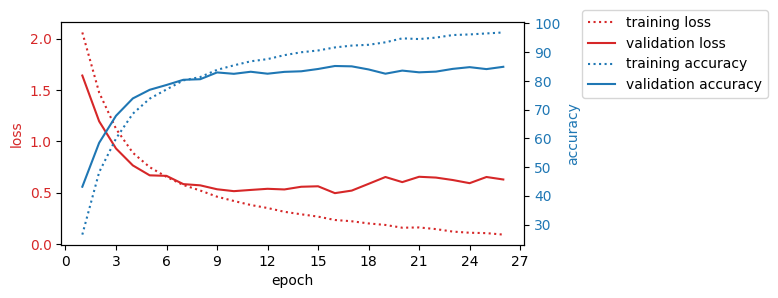


lr = 5e-05


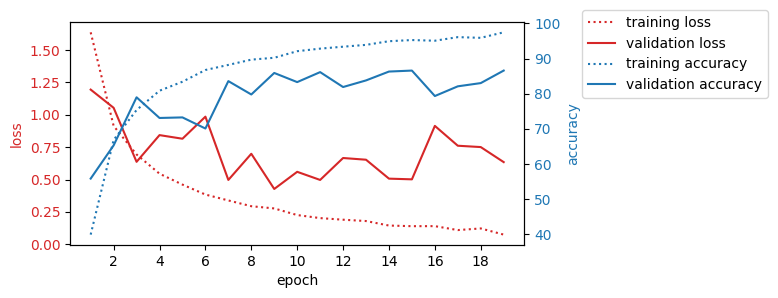


lr = 0.0001


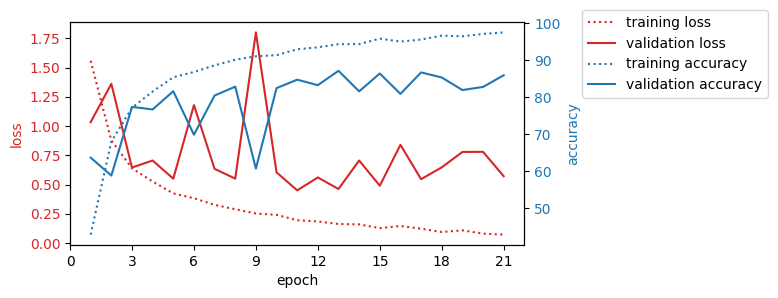


lr = 0.0005


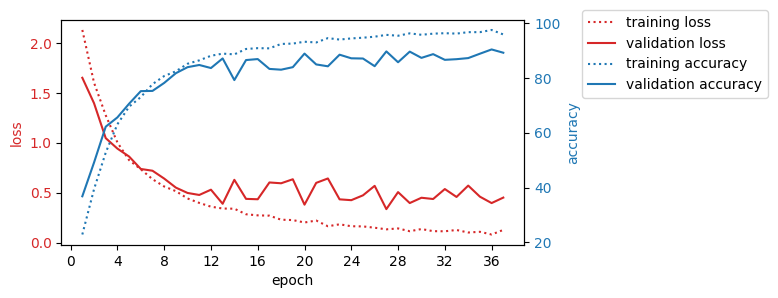

In [29]:
for lr in lrs:
    print(f"lr = {lr}")
    plotter0(model02_dict[lr])
    print()

In [30]:
# free up space
gc.collect()
torch.cuda.empty_cache()

## Train w/ my loss

### Linear

In [31]:
# train
model12_dict,model12_strings=trainer(n_epochs,lrs,alphas,"nn.Linear",noise_train_dataloader,noise_val_dataloader)

training for lr = 1e-05
training for alpha = 0.1
epoch: 1, time: 16.25
training loss (base/corr/combo):  2.08/0.01/2.08, accuracy: 24.75
validation loss (base/corr/combo):  1.69/0.01/1.69, accuracy: 40.88

epoch: 6, time: 15.47
training loss (base/corr/combo):  0.67/0.01/0.67, accuracy: 76.35
validation loss (base/corr/combo):  0.70/0.01/0.70, accuracy: 75.96

epoch: 11, time: 15.31
training loss (base/corr/combo):  0.39/0.01/0.39, accuracy: 86.29
validation loss (base/corr/combo):  0.72/0.01/0.72, accuracy: 78.76

epoch: 16, time: 15.29
training loss (base/corr/combo):  0.25/0.01/0.25, accuracy: 91.50
validation loss (base/corr/combo):  0.52/0.02/0.52, accuracy: 85.56

epoch: 21, time: 15.24
training loss (base/corr/combo):  0.14/0.01/0.15, accuracy: 95.28
validation loss (base/corr/combo):  0.81/0.01/0.81, accuracy: 81.96

Early stop at epoch 23

saved model as 'output/model_lr1e-05_layertypenn.Linear_alpha0.1_20240828-130303.pth'
training for alpha = 0.5
epoch: 1, time: 15.61
traini

In [32]:
# saving
time_stamp=time.strftime("%Y%m%d-%H%M%S")
torch.save(model12_dict, f'output/model12_dict_{time_stamp}.pt')
print(f"saved dictionary as 'model12_dict_{time_stamp}.pt'")

# reference for loading
print(model12_strings)

saved dictionary as 'model12_dict_20240828-161100.pt'
['output/model_lr1e-05_layertypenn.Linear_alpha0.1_20240828-130303.pth', 'output/model_lr1e-05_layertypenn.Linear_alpha0.5_20240828-130900.pth', 'output/model_lr1e-05_layertypenn.Linear_alpha1_20240828-131456.pth', 'output/model_lr1e-05_layertypenn.Linear_alpha10_20240828-132036.pth', 'output/model_lr1e-05_layertypenn.Linear_alpha50_20240828-133803.pth', 'output/model_lr1e-05_layertypenn.Linear_alpha100_20240828-135517.pth', 'output/model_lr5e-05_layertypenn.Linear_alpha0.1_20240828-140102.pth', 'output/model_lr5e-05_layertypenn.Linear_alpha0.5_20240828-140557.pth', 'output/model_lr5e-05_layertypenn.Linear_alpha1_20240828-141214.pth', 'output/model_lr5e-05_layertypenn.Linear_alpha10_20240828-141638.pth', 'output/model_lr5e-05_layertypenn.Linear_alpha50_20240828-142628.pth', 'output/model_lr5e-05_layertypenn.Linear_alpha100_20240828-143459.pth', 'output/model_lr0.0001_layertypenn.Linear_alpha0.1_20240828-144044.pth', 'output/model_lr

Learning rate = 1e-05


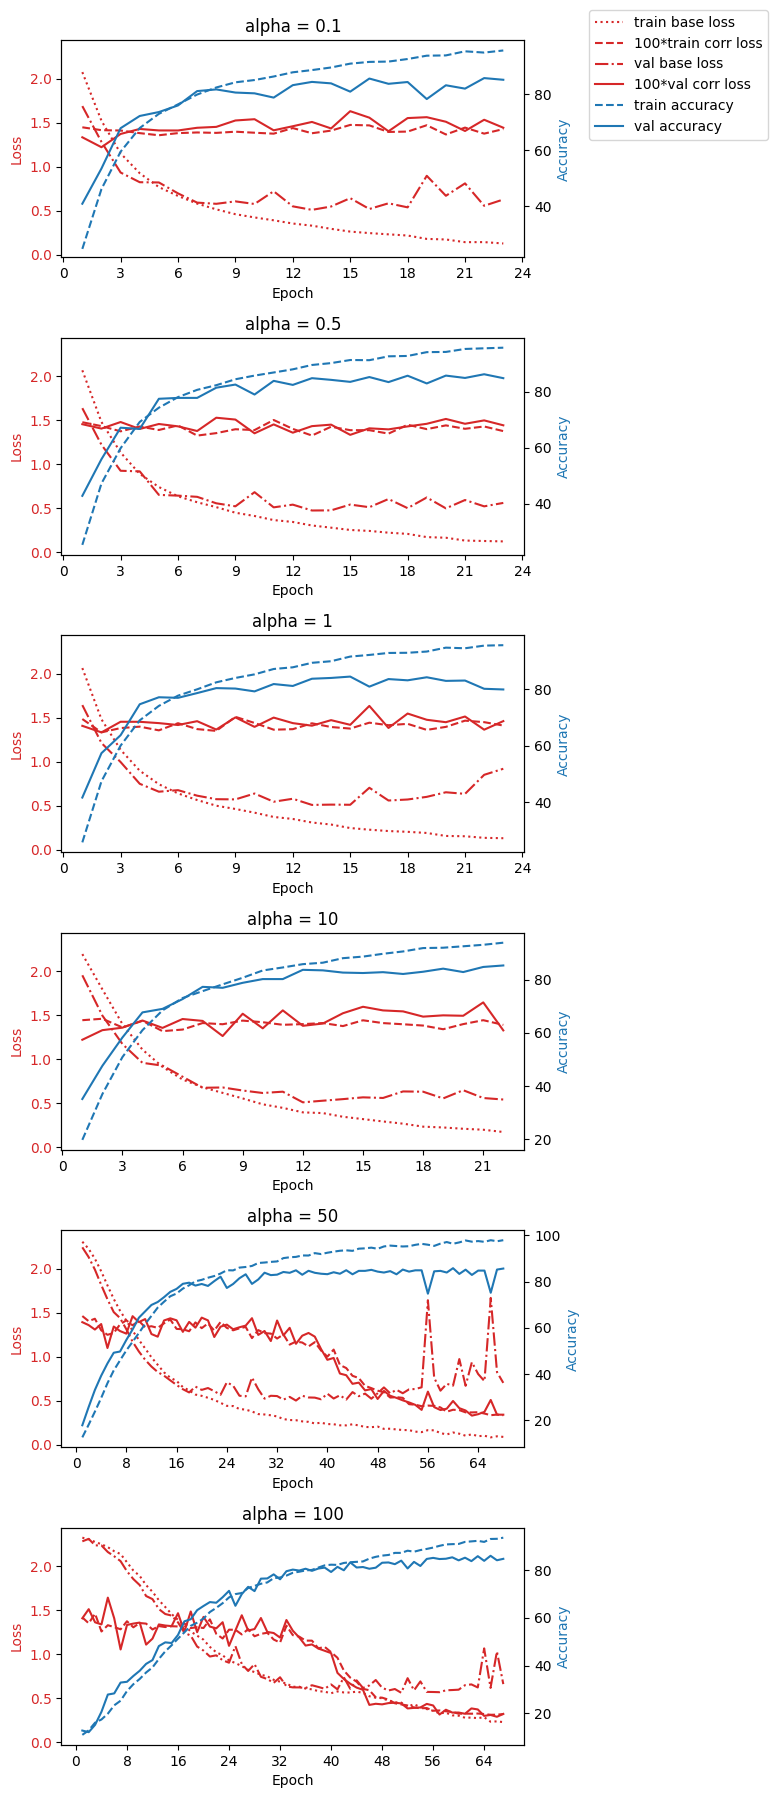


Learning rate = 5e-05


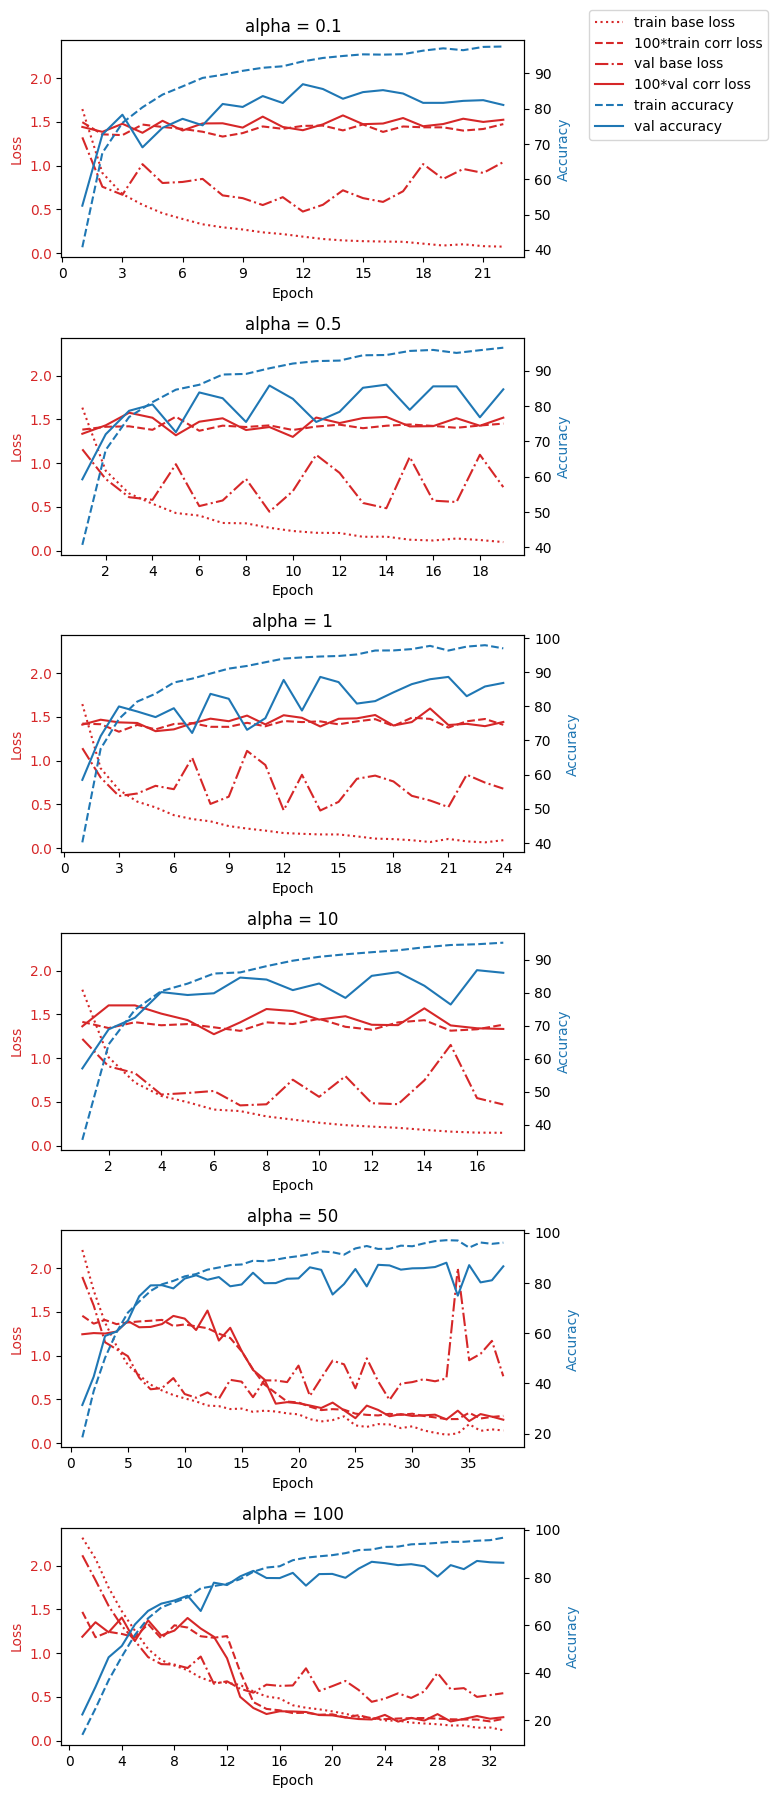


Learning rate = 0.0001


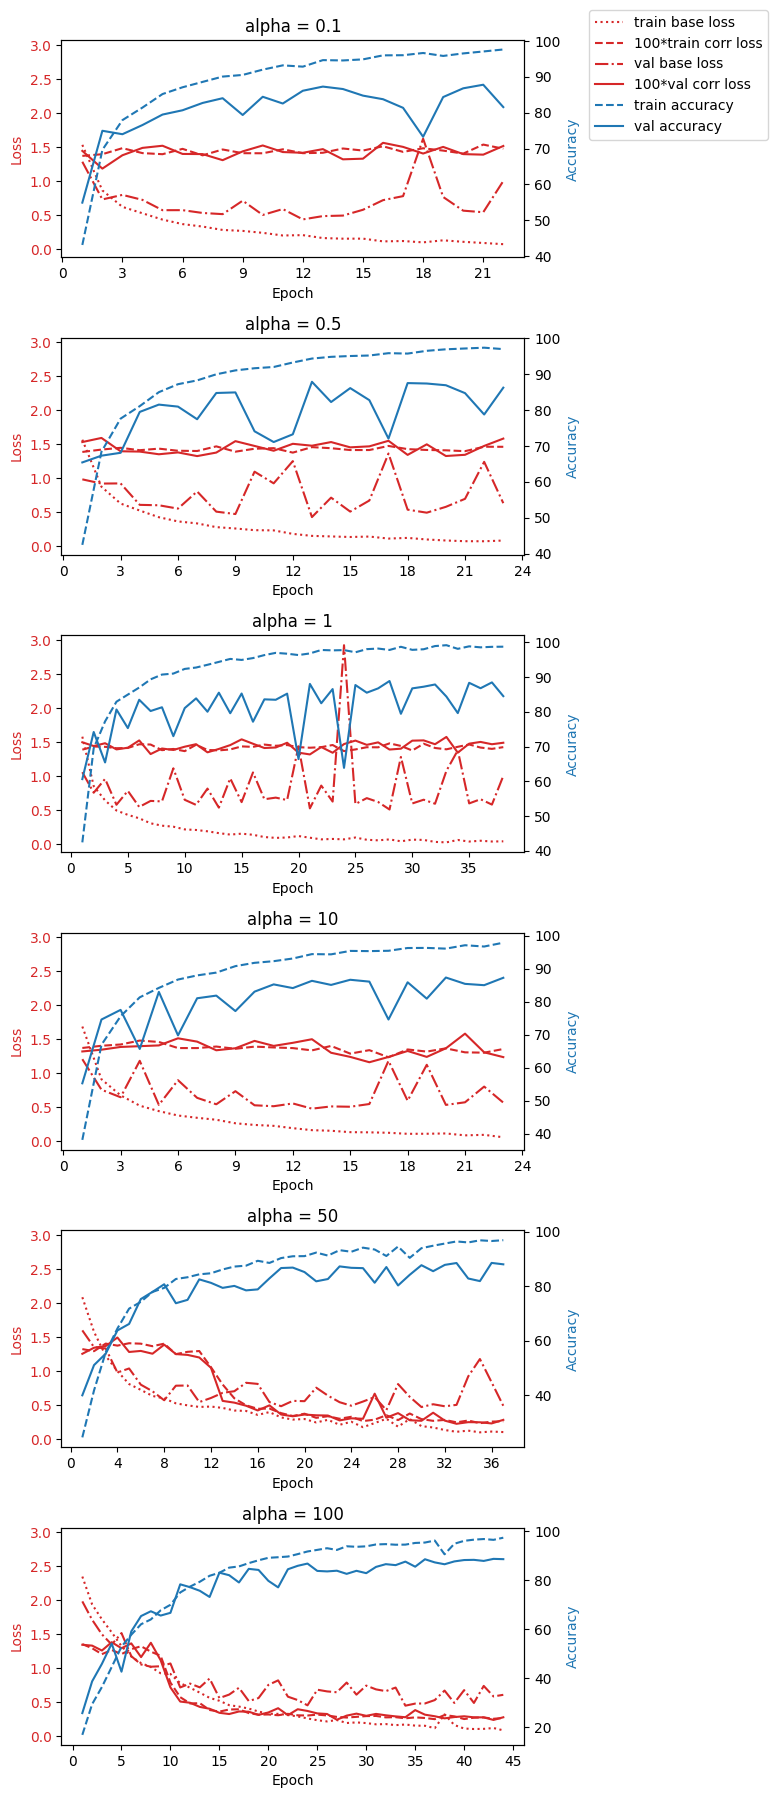


Learning rate = 0.0005


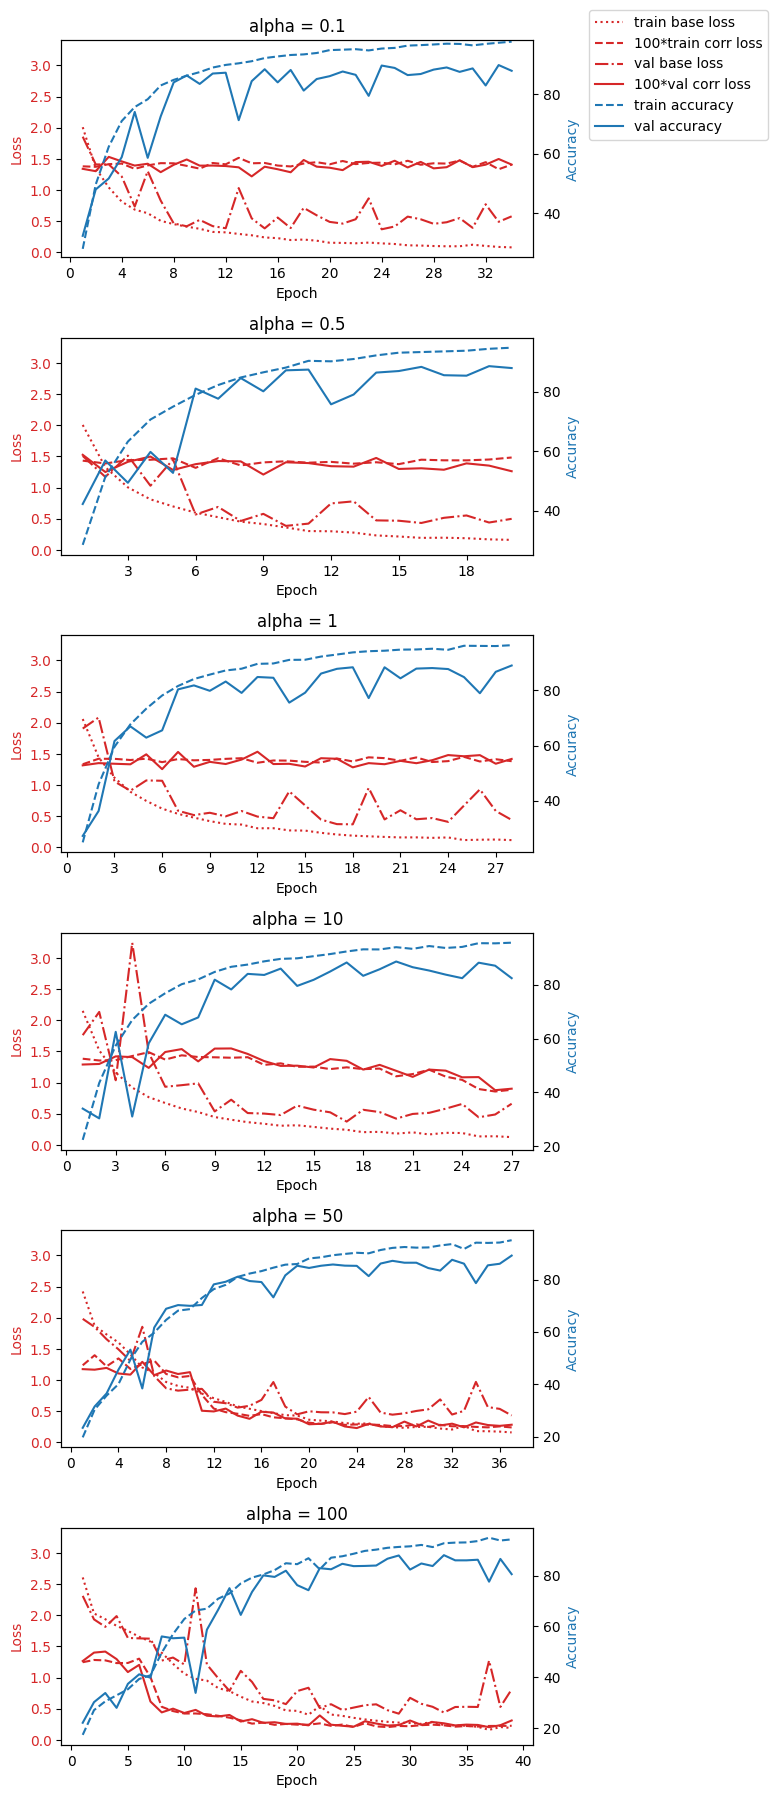

In [33]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter(alphas,model12_dict[lr],scaler=100)
    print()

Learning rate = 1e-05


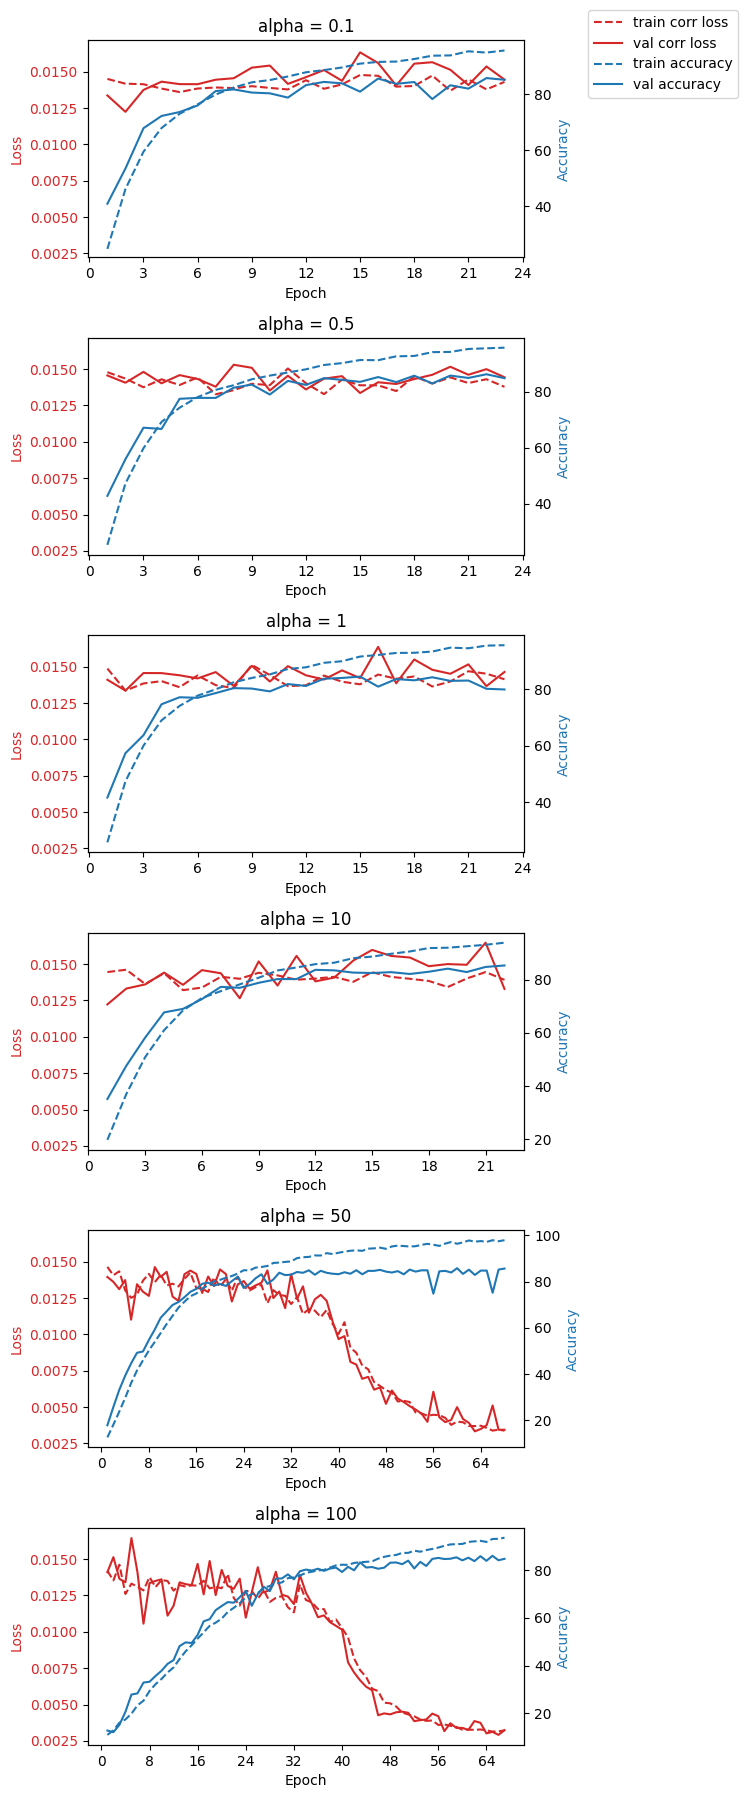


Learning rate = 5e-05


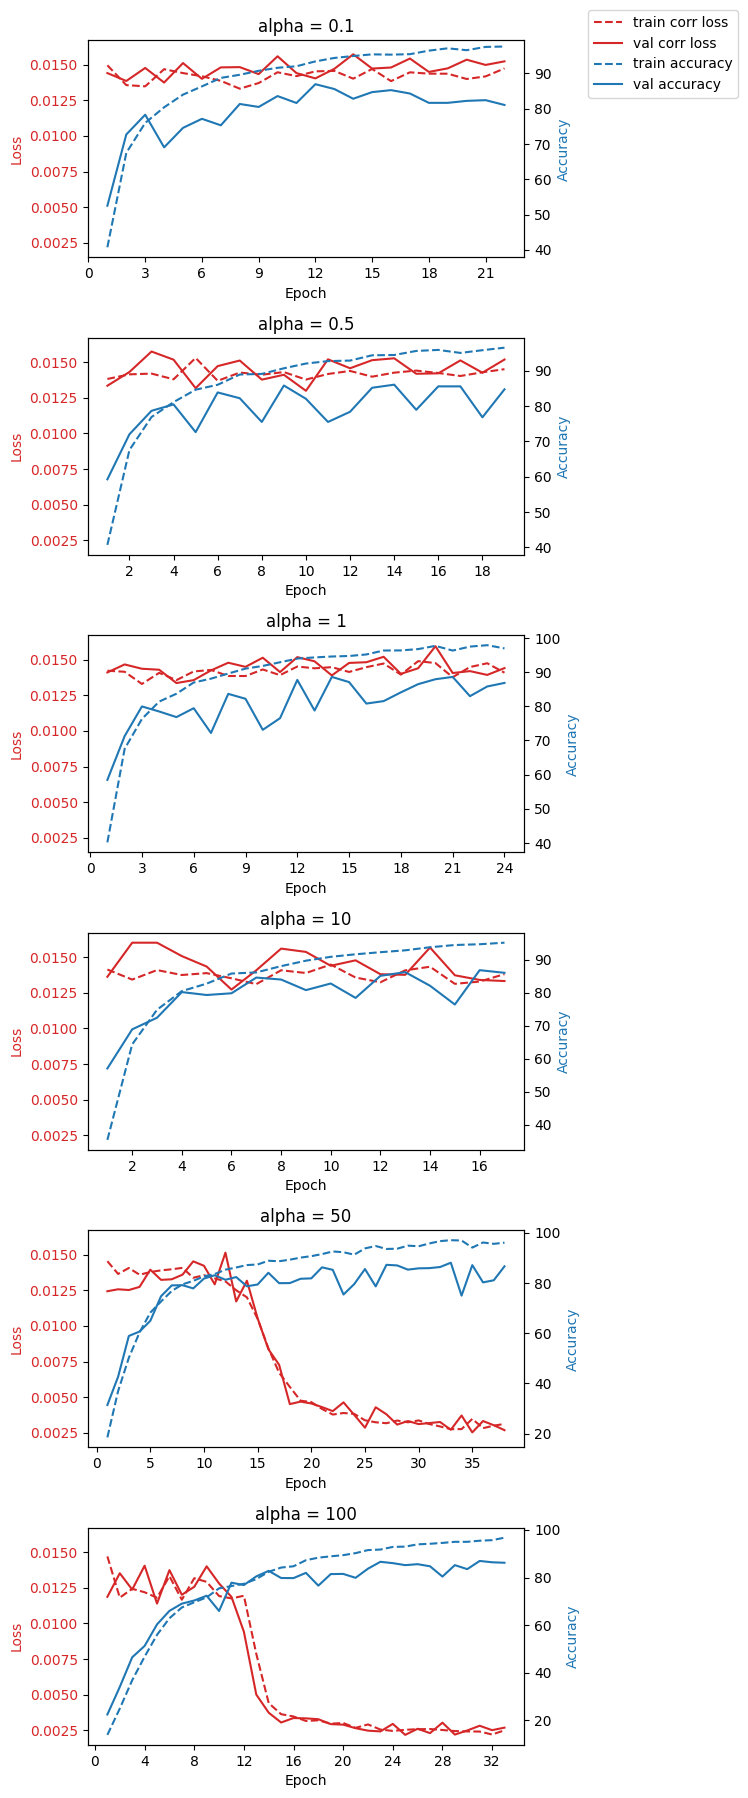


Learning rate = 0.0001


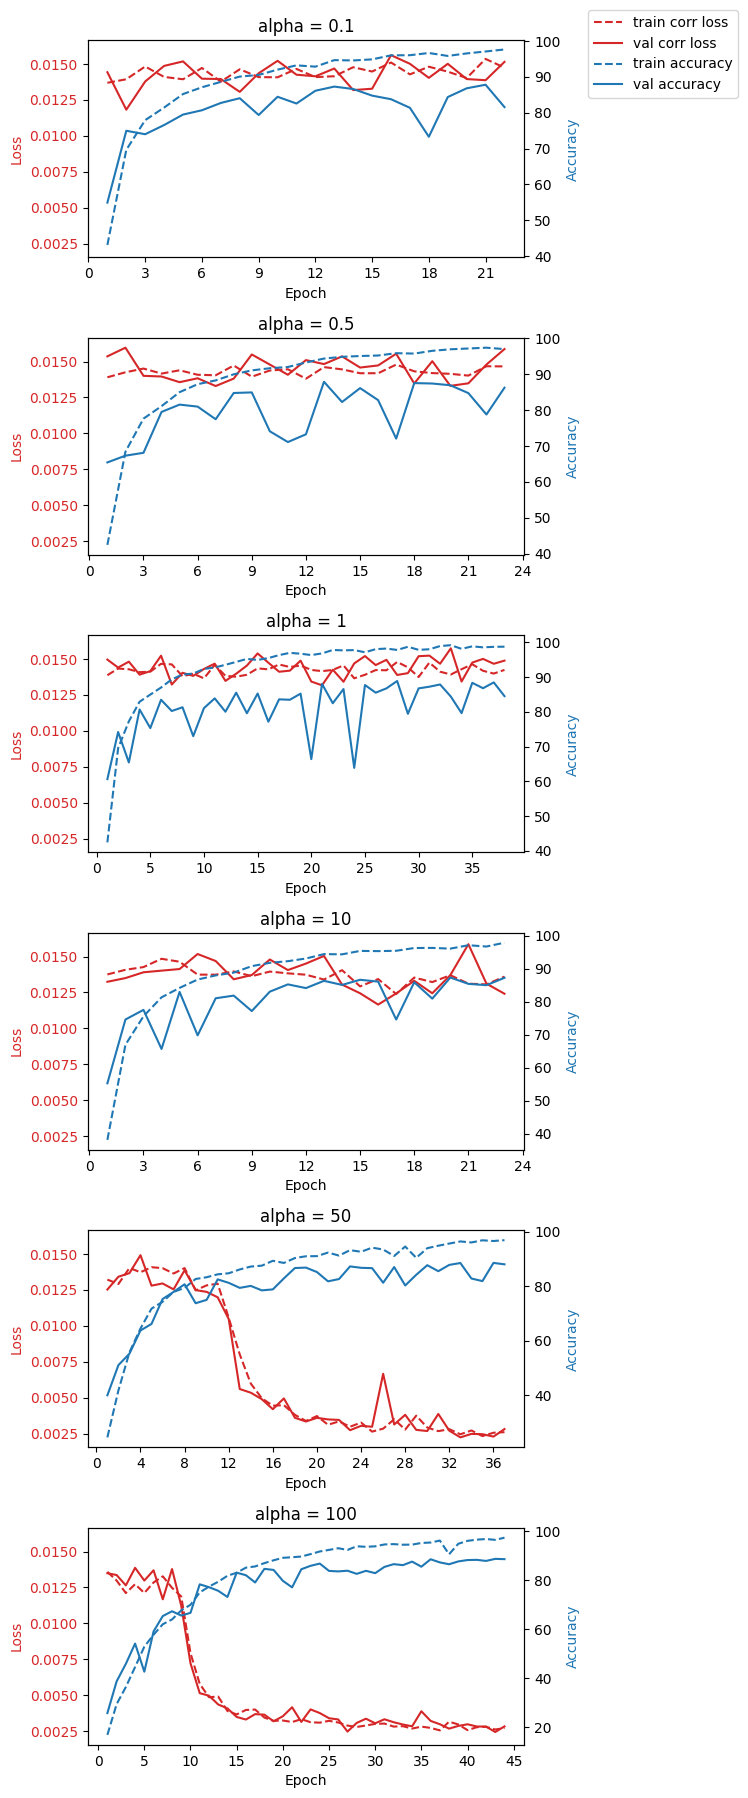


Learning rate = 0.0005


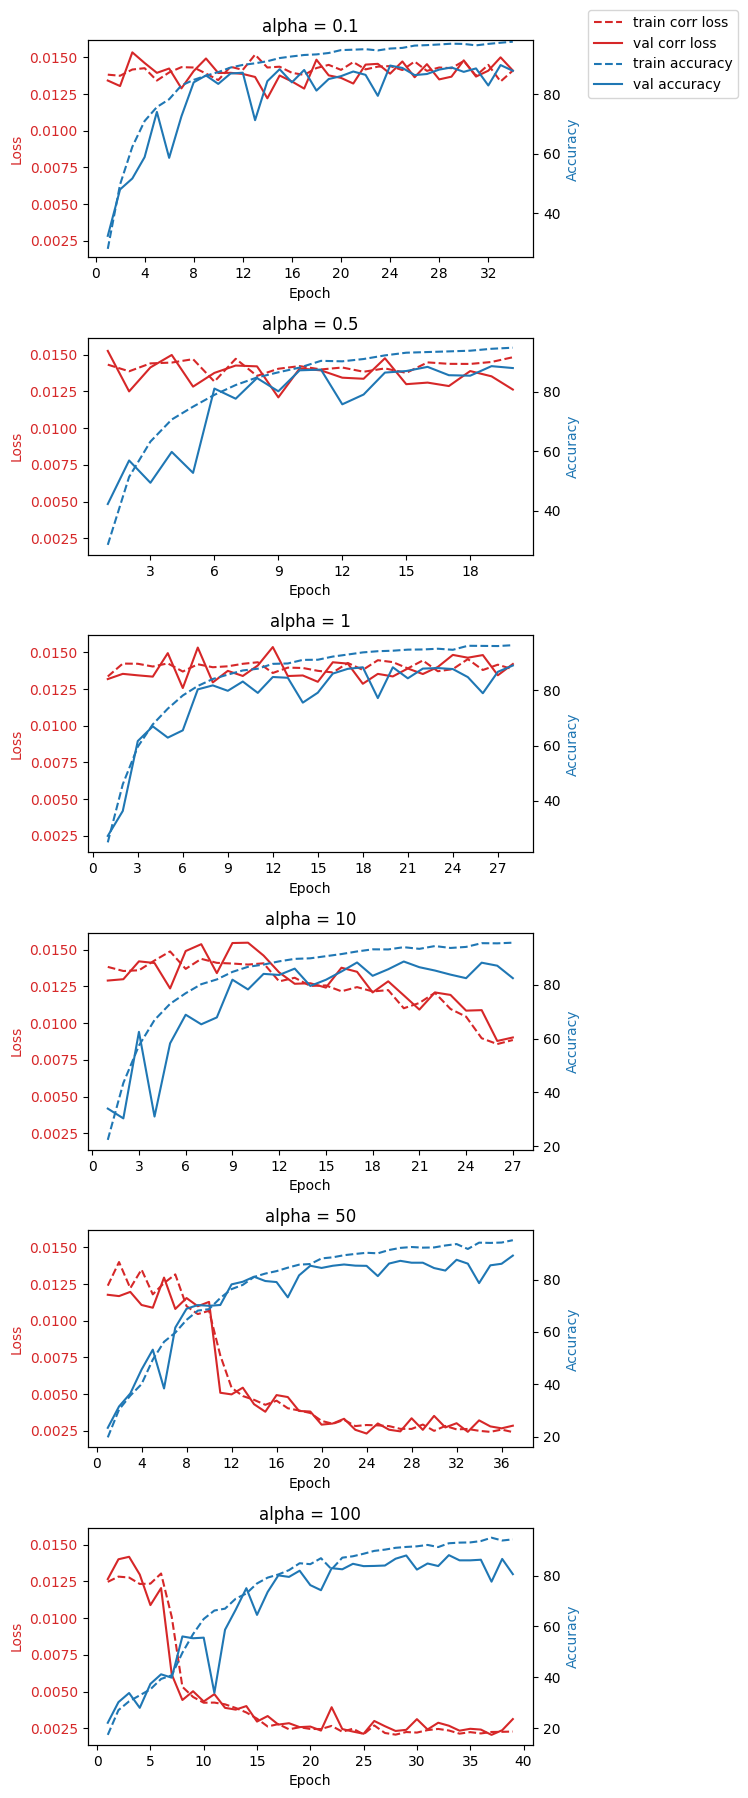

In [34]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter_corr(alphas,model12_dict[lr])
    print()

In [35]:
# free up space
gc.collect()
torch.cuda.empty_cache()

### Conv2d

In [36]:
# train
model22_dict,model22_strings=trainer(n_epochs,lrs,alphas,"nn.Conv2d",noise_train_dataloader,noise_val_dataloader)

training for lr = 1e-05
training for alpha = 0.1
epoch: 1, time: 20.00
training loss (base/corr/combo):  2.07/0.00/2.07, accuracy: 25.41
validation loss (base/corr/combo):  1.68/0.00/1.68, accuracy: 40.96

epoch: 6, time: 20.03
training loss (base/corr/combo):  0.67/0.00/0.67, accuracy: 76.57
validation loss (base/corr/combo):  0.74/0.00/0.74, accuracy: 74.60

epoch: 11, time: 19.81
training loss (base/corr/combo):  0.39/0.00/0.39, accuracy: 86.41
validation loss (base/corr/combo):  0.51/0.00/0.51, accuracy: 84.44

epoch: 16, time: 20.04
training loss (base/corr/combo):  0.24/0.00/0.24, accuracy: 91.73
validation loss (base/corr/combo):  0.55/0.00/0.55, accuracy: 84.64

epoch: 21, time: 20.12
training loss (base/corr/combo):  0.15/0.00/0.15, accuracy: 94.85
validation loss (base/corr/combo):  0.57/0.00/0.57, accuracy: 84.64

Early stop at epoch 21

saved model as 'output/model_lr1e-05_layertypenn.Conv2d_alpha0.1_20240828-161821.pth'
training for alpha = 0.5
epoch: 1, time: 20.31
traini

In [37]:
# saving
time_stamp=time.strftime("%Y%m%d-%H%M%S")
torch.save(model22_dict, f'output/model22_dict_{time_stamp}.pt')
print(f"saved dictionary as 'model22_dict_{time_stamp}.pt'")

# reference for loading
print(model22_strings)

saved dictionary as 'model22_dict_20240828-191847.pt'
['output/model_lr1e-05_layertypenn.Conv2d_alpha0.1_20240828-161821.pth', 'output/model_lr1e-05_layertypenn.Conv2d_alpha0.5_20240828-162646.pth', 'output/model_lr1e-05_layertypenn.Conv2d_alpha1_20240828-163527.pth', 'output/model_lr1e-05_layertypenn.Conv2d_alpha10_20240828-164307.pth', 'output/model_lr1e-05_layertypenn.Conv2d_alpha50_20240828-165228.pth', 'output/model_lr1e-05_layertypenn.Conv2d_alpha100_20240828-170008.pth', 'output/model_lr5e-05_layertypenn.Conv2d_alpha0.1_20240828-170529.pth', 'output/model_lr5e-05_layertypenn.Conv2d_alpha0.5_20240828-171210.pth', 'output/model_lr5e-05_layertypenn.Conv2d_alpha1_20240828-171832.pth', 'output/model_lr5e-05_layertypenn.Conv2d_alpha10_20240828-172453.pth', 'output/model_lr5e-05_layertypenn.Conv2d_alpha50_20240828-173134.pth', 'output/model_lr5e-05_layertypenn.Conv2d_alpha100_20240828-173758.pth', 'output/model_lr0.0001_layertypenn.Conv2d_alpha0.1_20240828-174740.pth', 'output/model_lr

Learning rate = 1e-05


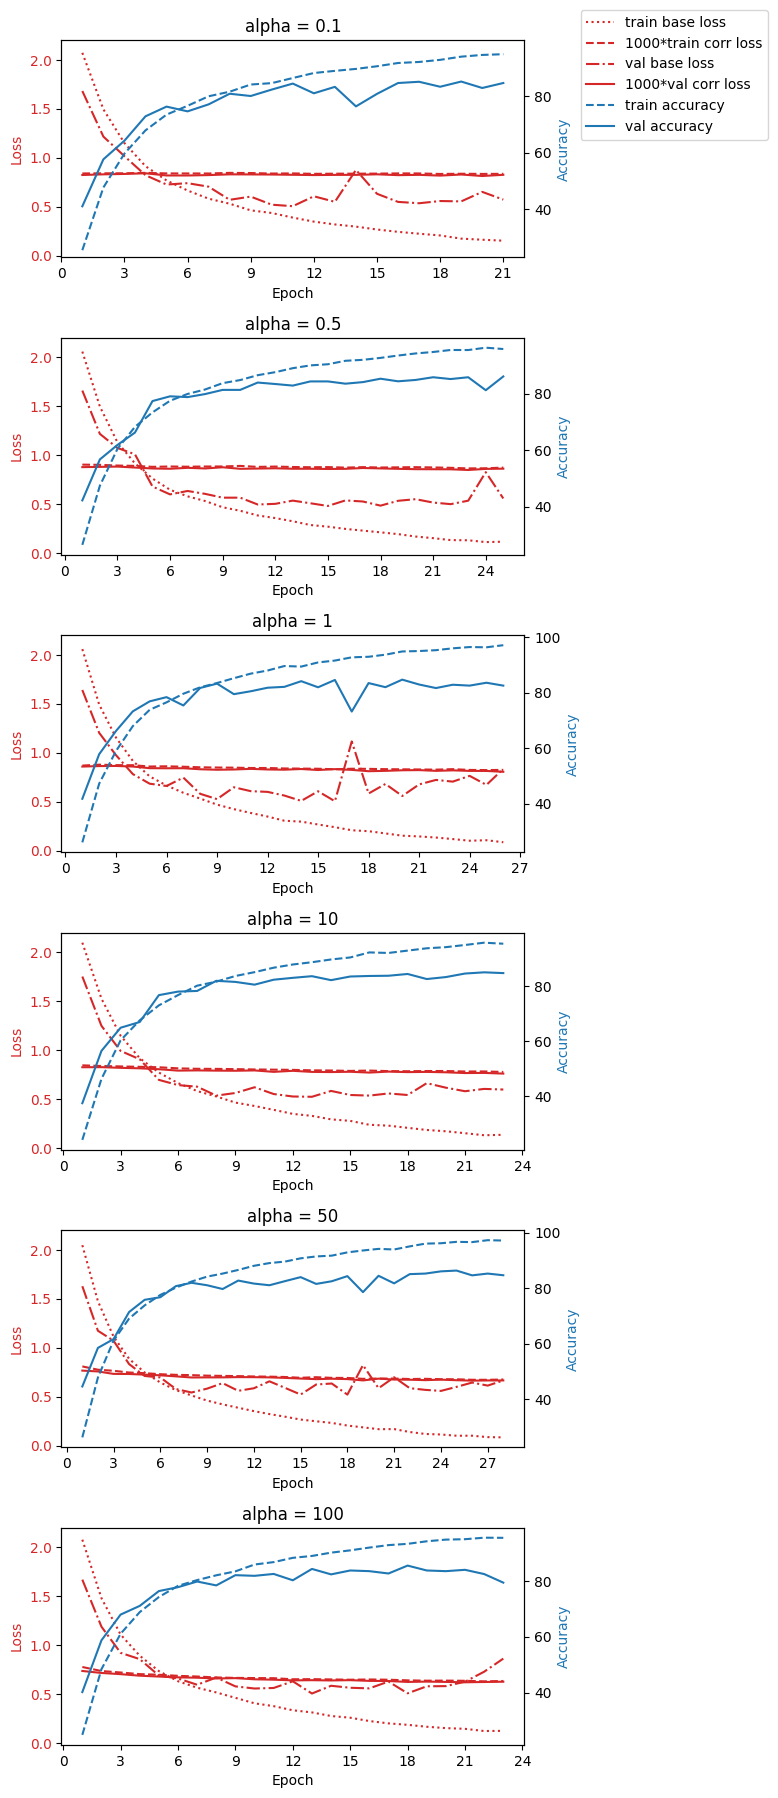


Learning rate = 5e-05


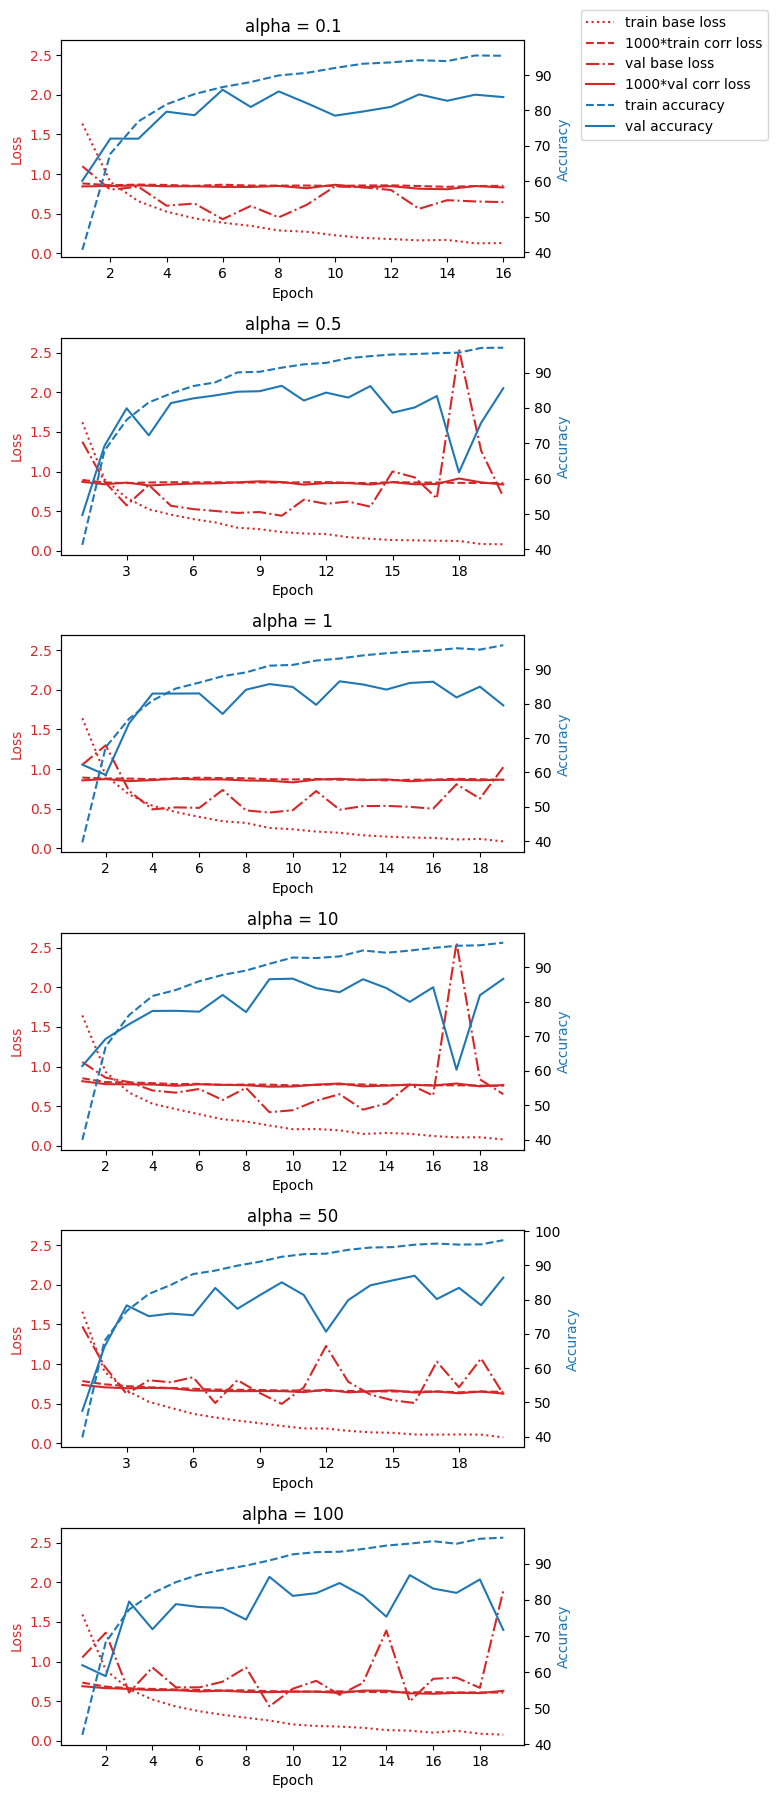


Learning rate = 0.0001


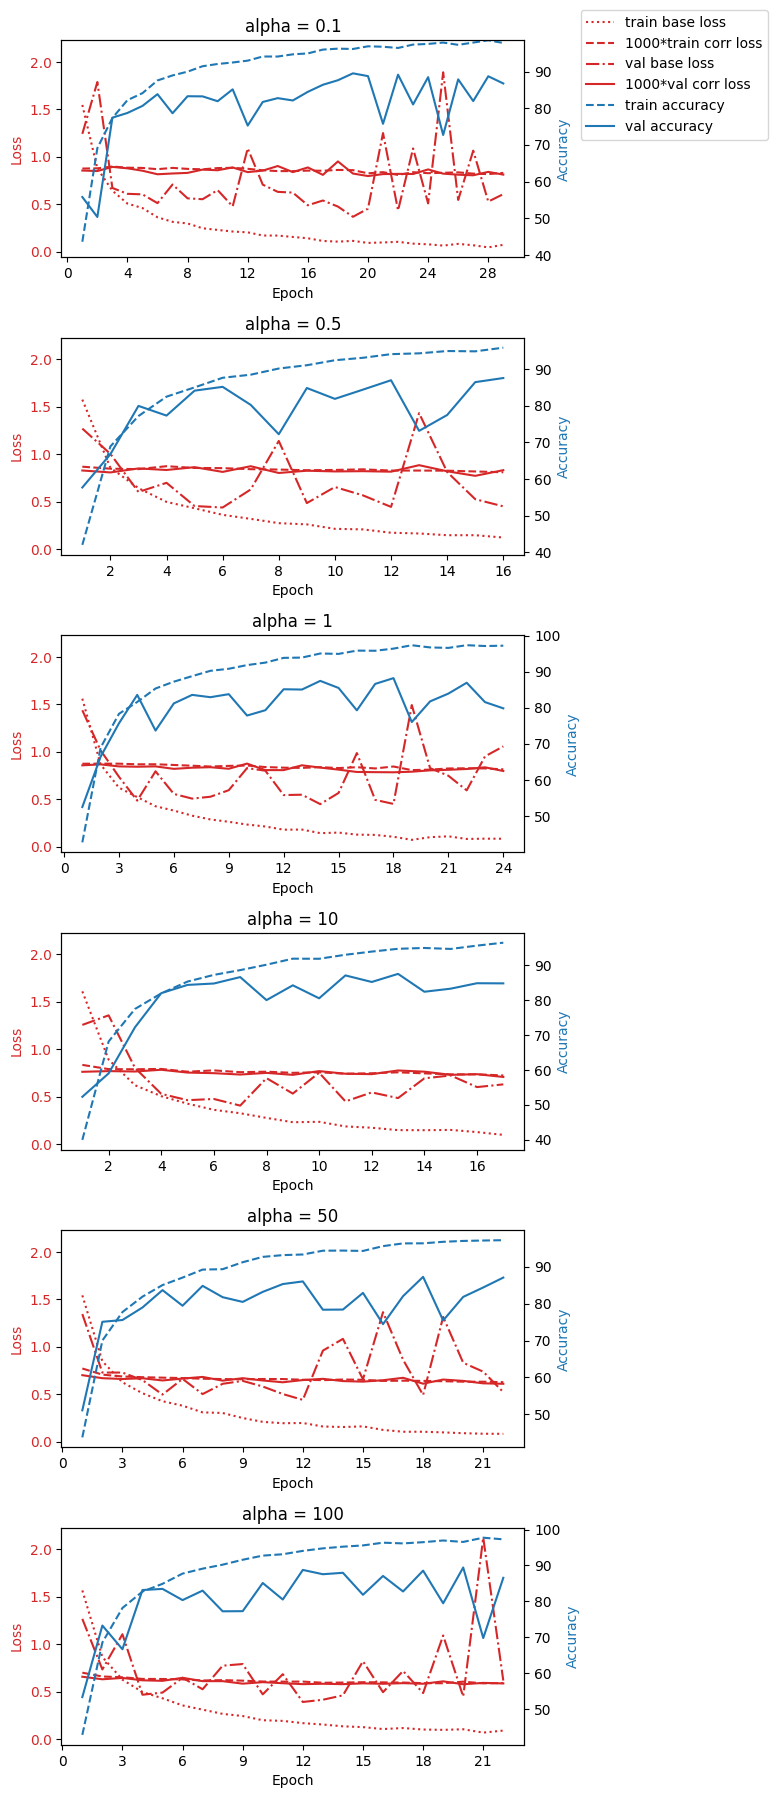


Learning rate = 0.0005


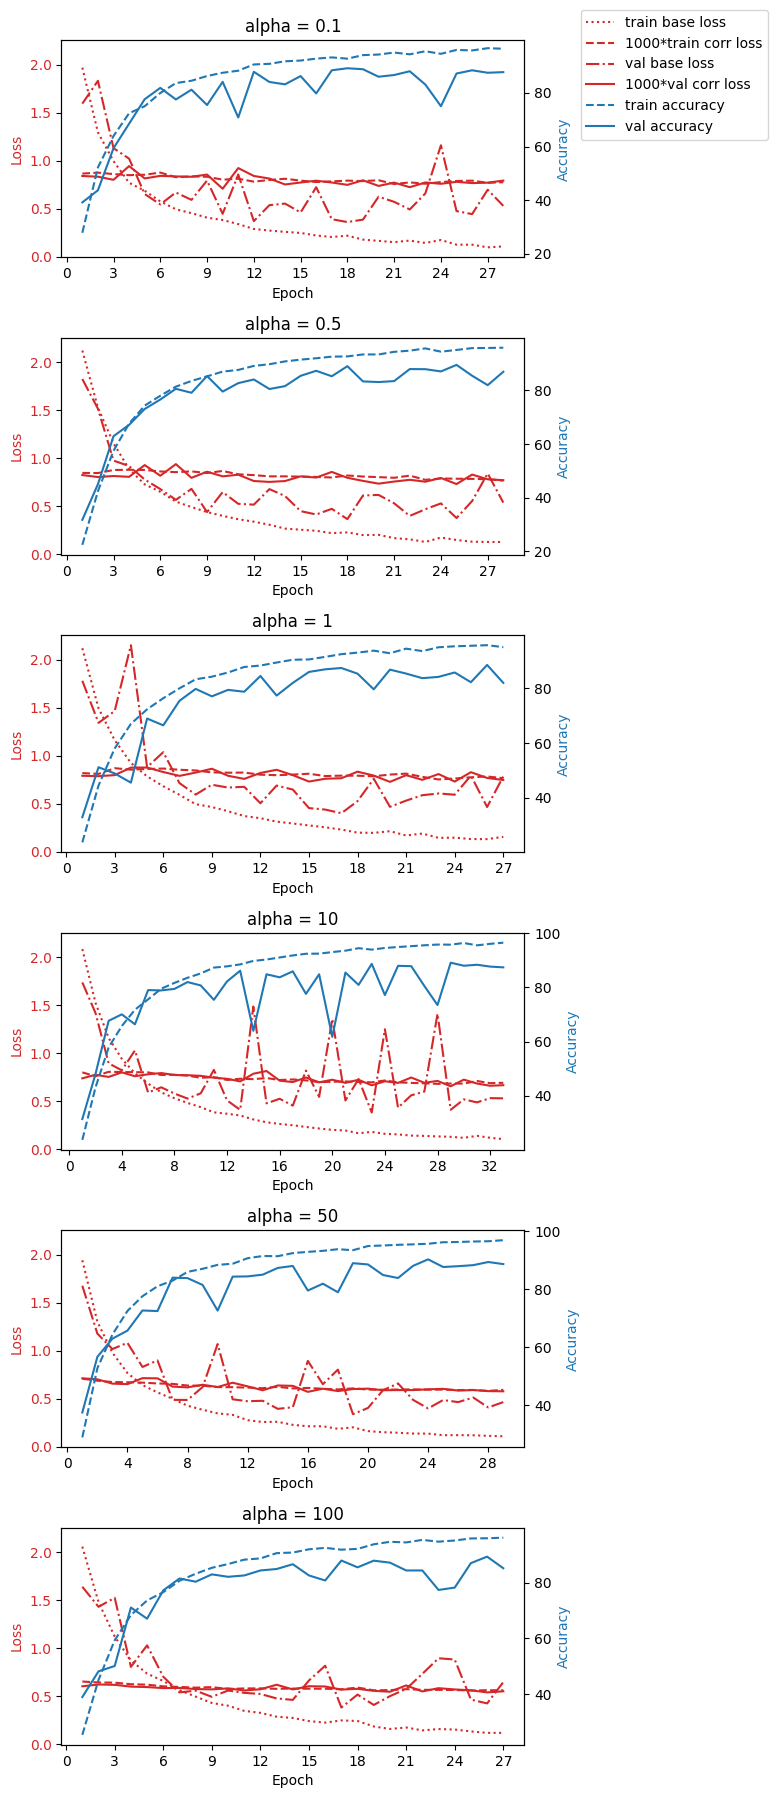

In [38]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter(alphas,model22_dict[lr],scaler=1000)
    print()

Learning rate = 1e-05


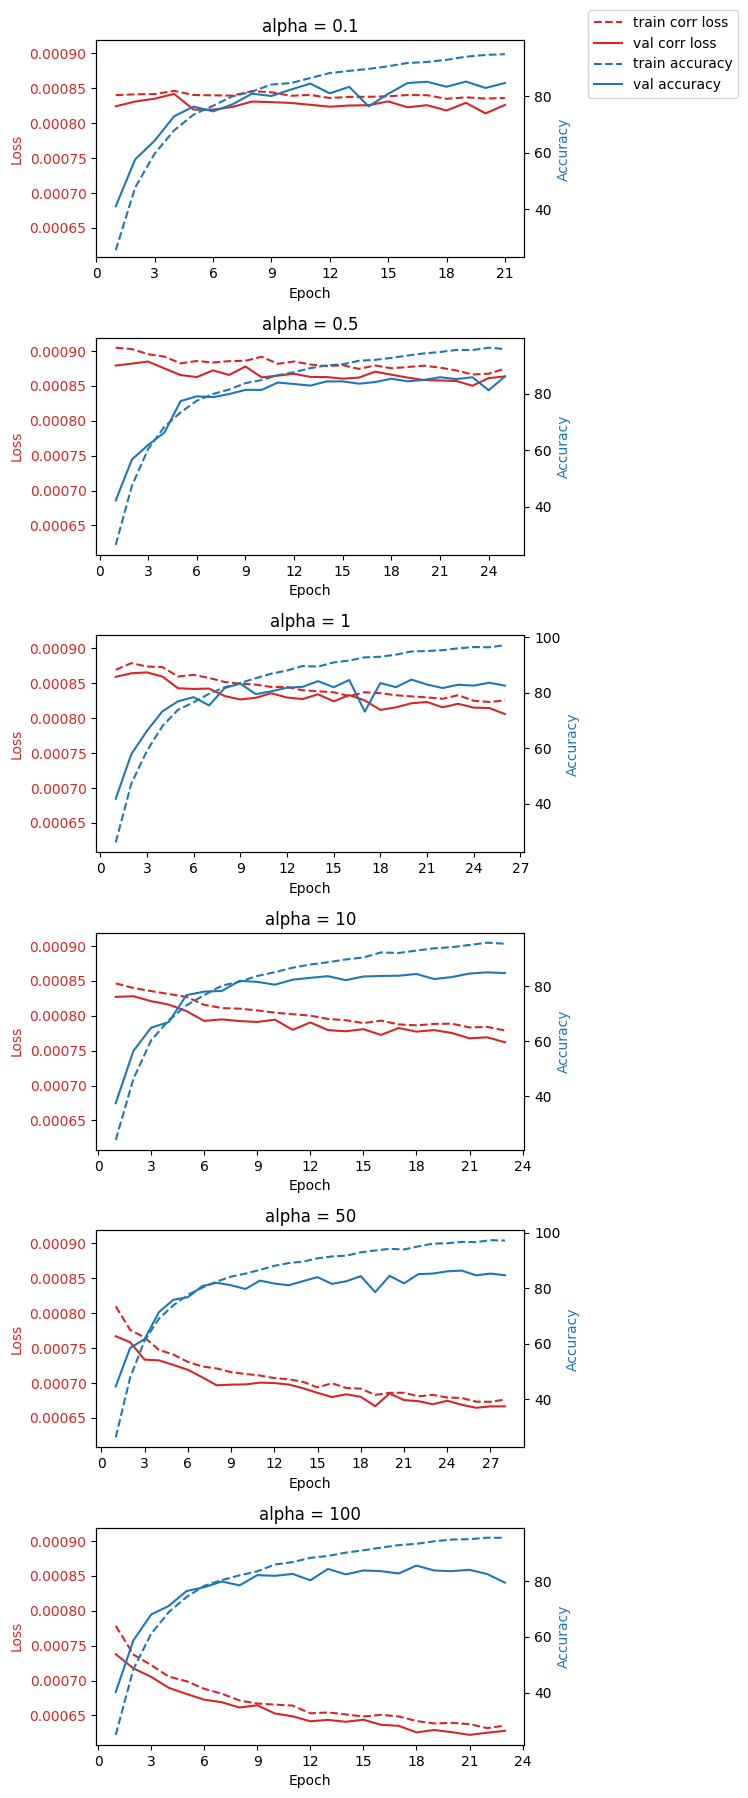


Learning rate = 5e-05


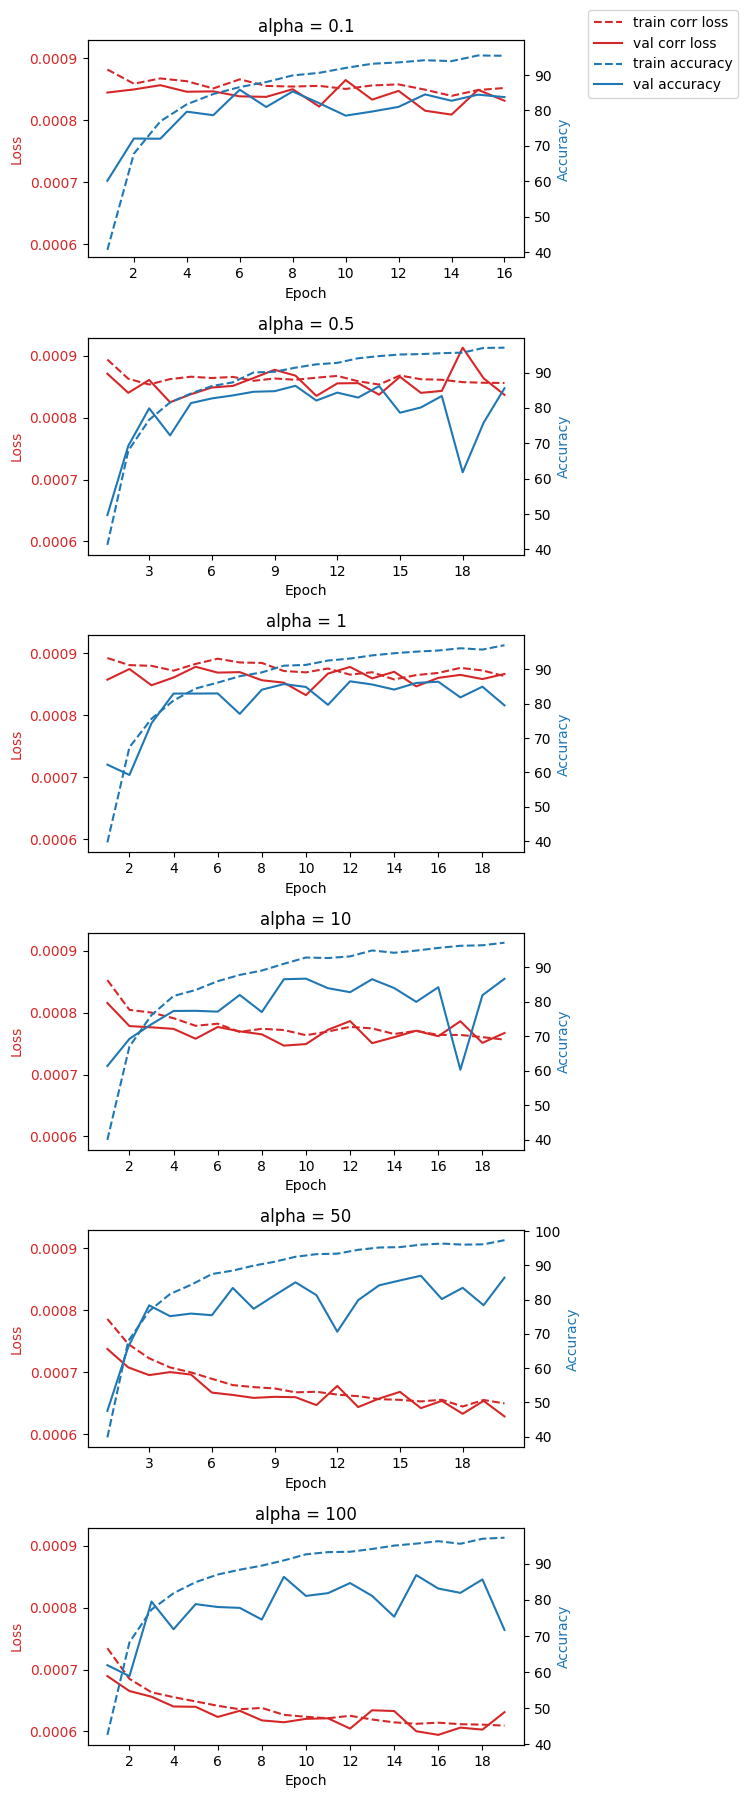


Learning rate = 0.0001


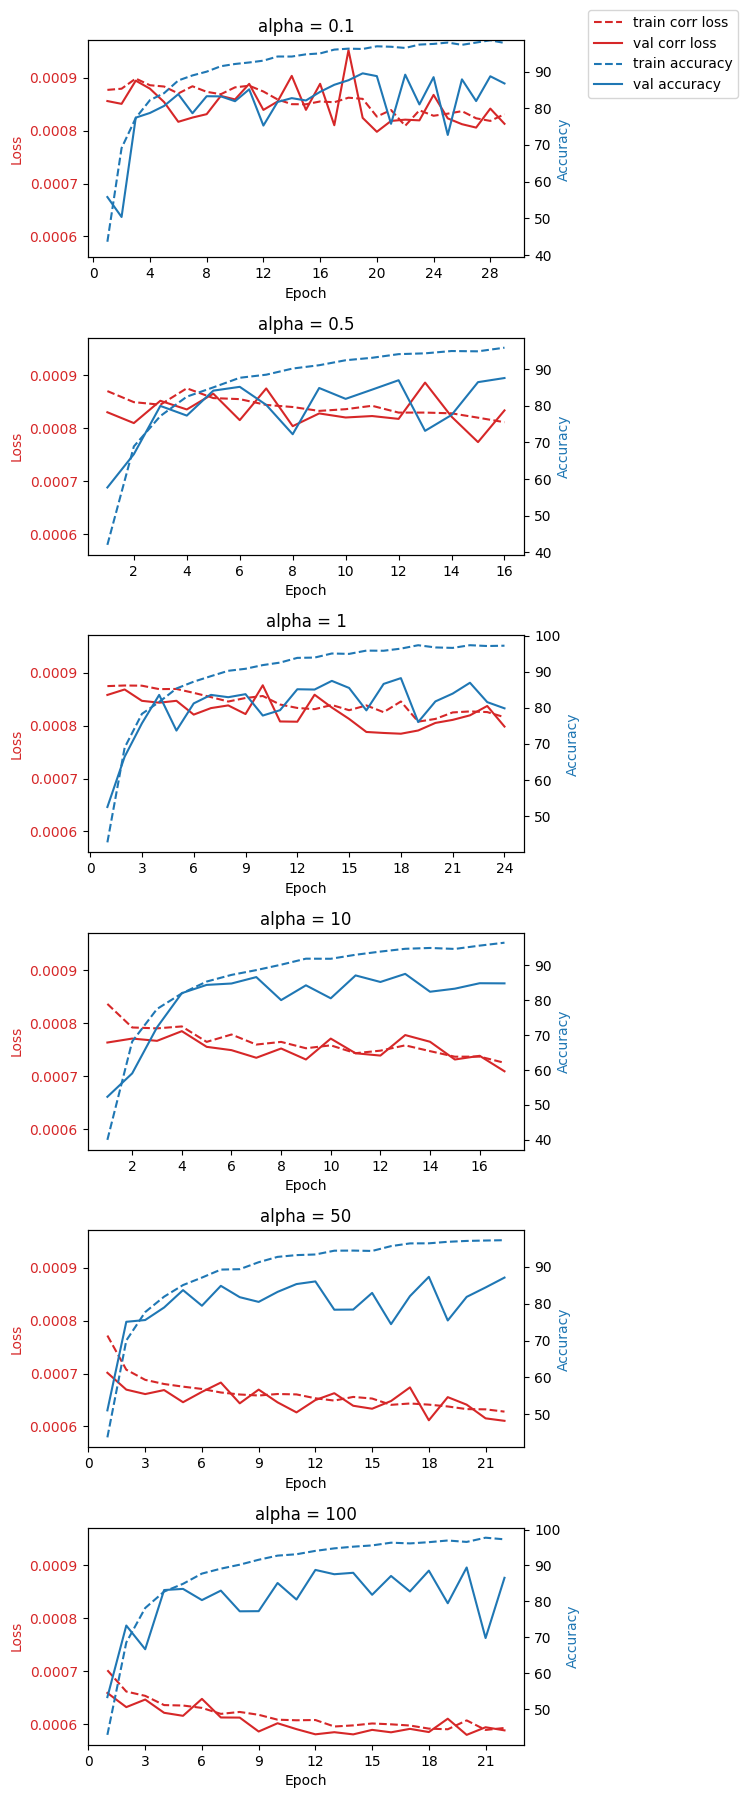


Learning rate = 0.0005


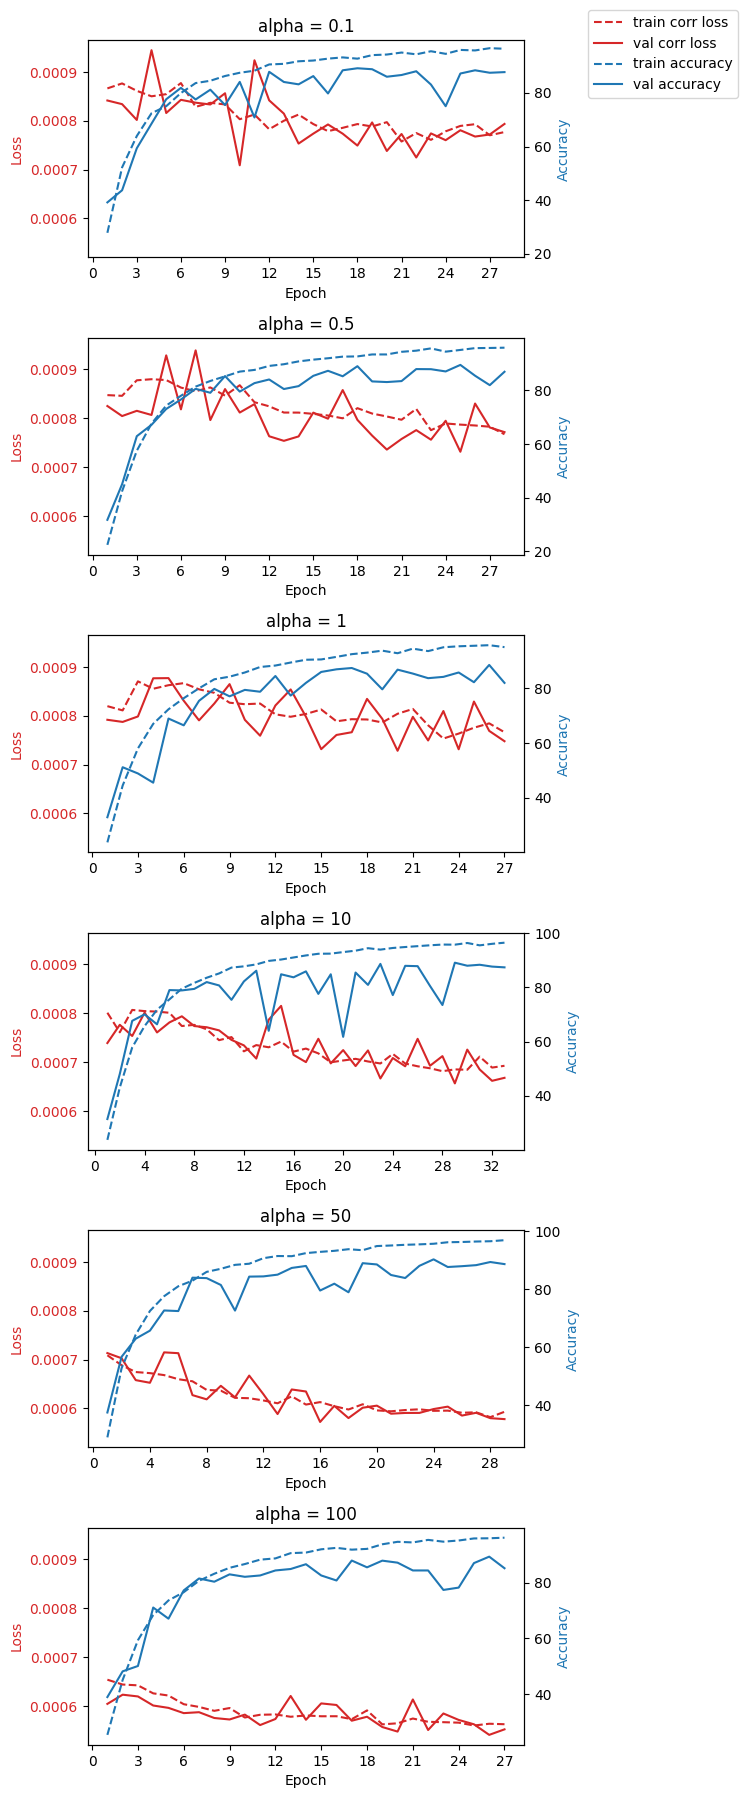

In [39]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter_corr(alphas,model22_dict[lr])
    print()

In [40]:
# free up space
gc.collect()
torch.cuda.empty_cache()

### Both

In [41]:
# train
model32_dict,model32_strings=trainer(n_epochs,lrs,alphas,"both",noise_train_dataloader,noise_val_dataloader)

training for lr = 1e-05
training for alpha = 0.1
epoch: 1, time: 19.96
training loss (base/corr/combo):  2.07/0.01/2.07, accuracy: 26.01
validation loss (base/corr/combo):  1.65/0.01/1.65, accuracy: 42.20

epoch: 6, time: 20.04
training loss (base/corr/combo):  0.66/0.01/0.66, accuracy: 77.77
validation loss (base/corr/combo):  0.61/0.01/0.61, accuracy: 79.76

epoch: 11, time: 20.04
training loss (base/corr/combo):  0.40/0.01/0.40, accuracy: 86.19
validation loss (base/corr/combo):  0.55/0.01/0.55, accuracy: 82.44

epoch: 16, time: 20.13
training loss (base/corr/combo):  0.24/0.01/0.24, accuracy: 91.90
validation loss (base/corr/combo):  0.65/0.01/0.65, accuracy: 81.28

epoch: 21, time: 19.92
training loss (base/corr/combo):  0.16/0.01/0.16, accuracy: 94.55
validation loss (base/corr/combo):  0.60/0.01/0.60, accuracy: 83.72

Early stop at epoch 24

saved model as 'output/model_lr1e-05_layertypeboth_alpha0.1_20240828-192707.pth'
training for alpha = 0.5
epoch: 1, time: 20.16
training lo

In [42]:
# saving
time_stamp=time.strftime("%Y%m%d-%H%M%S")
torch.save(model32_dict, f'output/model32_dict_{time_stamp}.pt')
print(f"saved dictionary as 'model32_dict_{time_stamp}.pt'")

# reference for loading
print(model32_strings)

saved dictionary as 'model32_dict_20240828-231516.pt'
['output/model_lr1e-05_layertypeboth_alpha0.1_20240828-192707.pth', 'output/model_lr1e-05_layertypeboth_alpha0.5_20240828-193555.pth', 'output/model_lr1e-05_layertypeboth_alpha1_20240828-194424.pth', 'output/model_lr1e-05_layertypeboth_alpha10_20240828-195107.pth', 'output/model_lr1e-05_layertypeboth_alpha50_20240828-200049.pth', 'output/model_lr1e-05_layertypeboth_alpha100_20240828-201117.pth', 'output/model_lr5e-05_layertypeboth_alpha0.1_20240828-201945.pth', 'output/model_lr5e-05_layertypeboth_alpha0.5_20240828-202713.pth', 'output/model_lr5e-05_layertypeboth_alpha1_20240828-203258.pth', 'output/model_lr5e-05_layertypeboth_alpha10_20240828-204006.pth', 'output/model_lr5e-05_layertypeboth_alpha50_20240828-204817.pth', 'output/model_lr5e-05_layertypeboth_alpha100_20240828-210225.pth', 'output/model_lr0.0001_layertypeboth_alpha0.1_20240828-210936.pth', 'output/model_lr0.0001_layertypeboth_alpha0.5_20240828-211822.pth', 'output/model

Learning rate = 1e-05


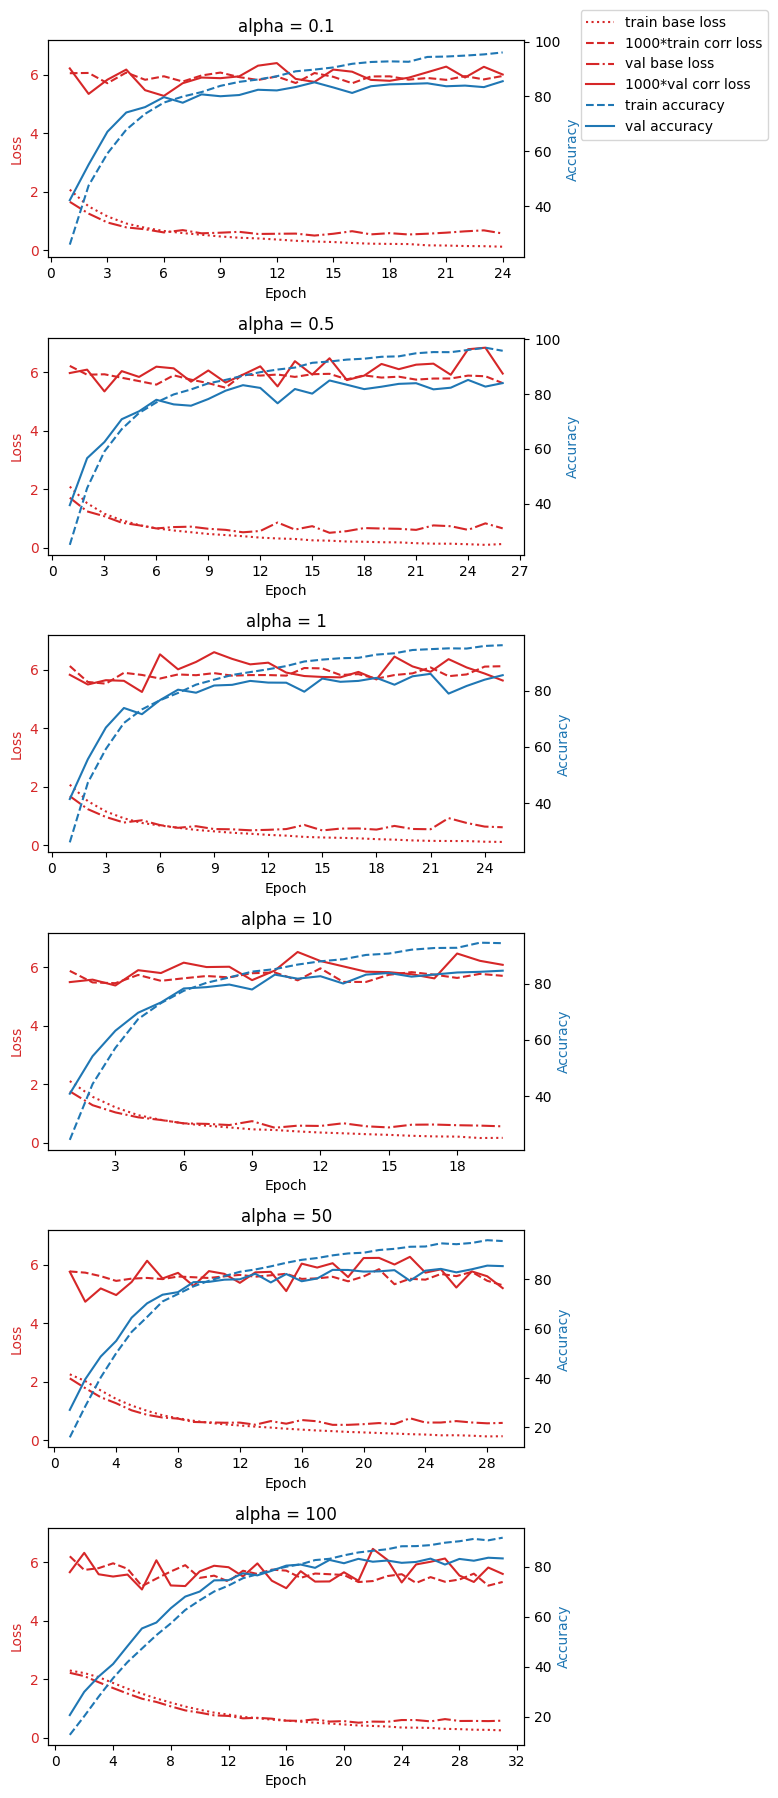

Learning rate = 5e-05


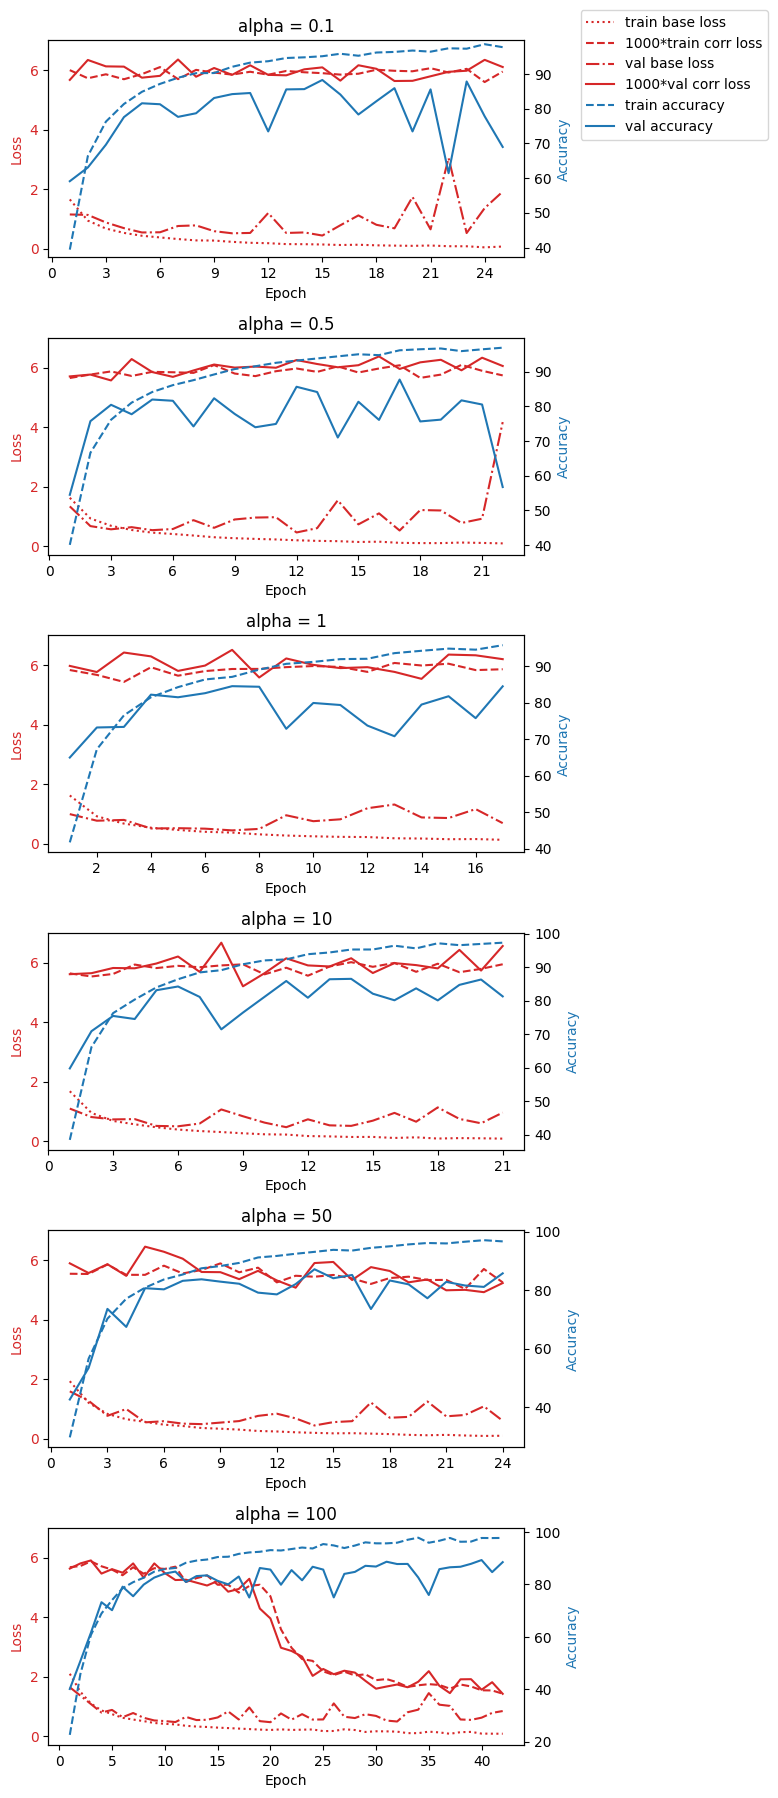

Learning rate = 0.0001


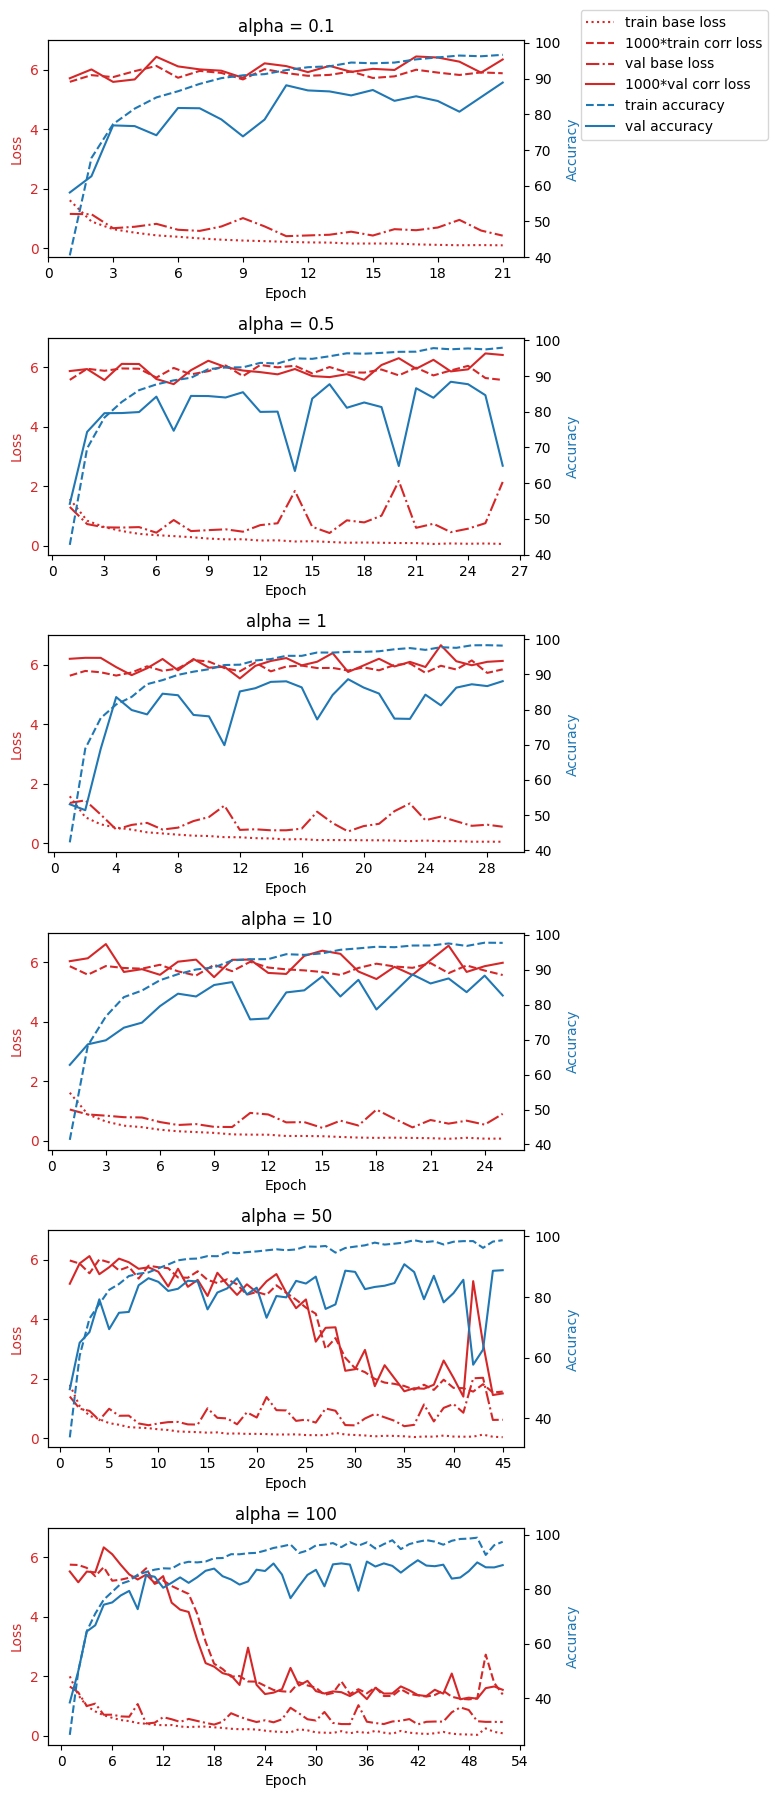

Learning rate = 0.0005


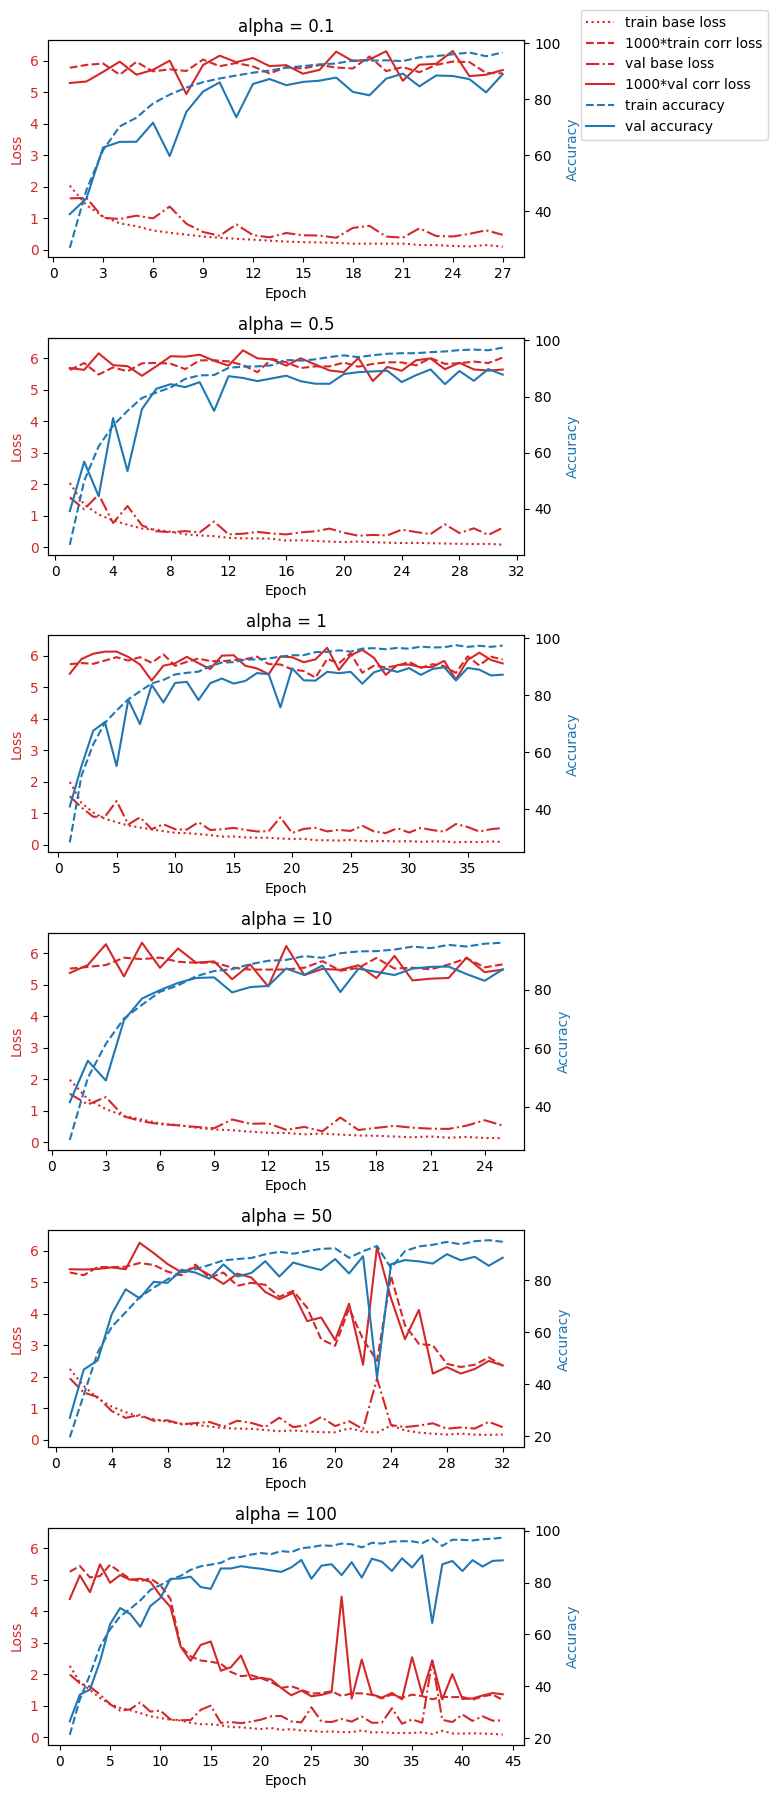

In [43]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter(alphas,model32_dict[lr],scaler=1000)

Learning rate = 1e-05


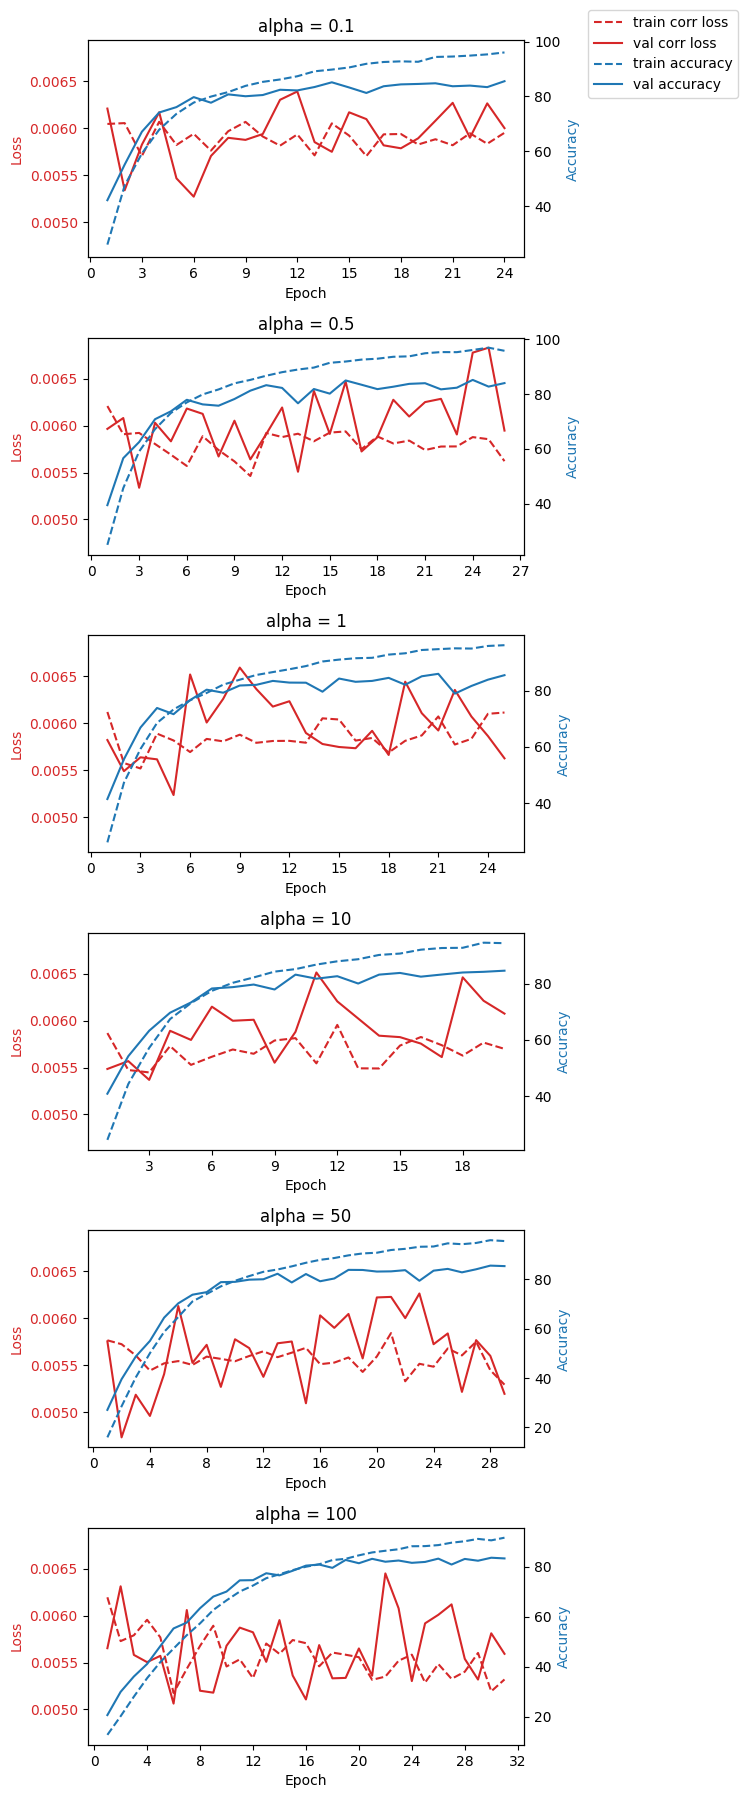

Learning rate = 5e-05


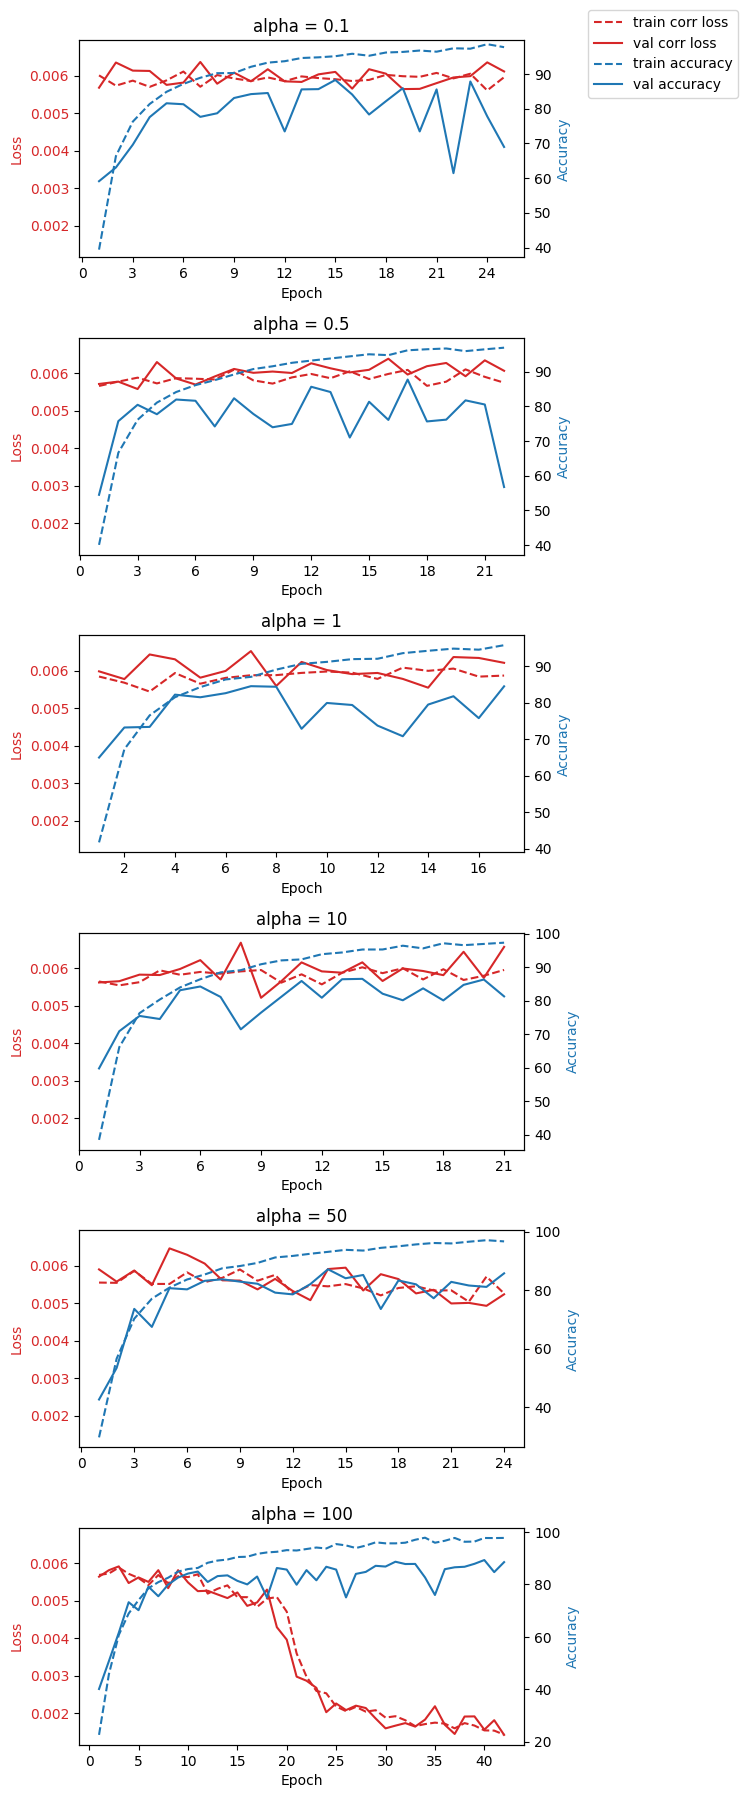

Learning rate = 0.0001


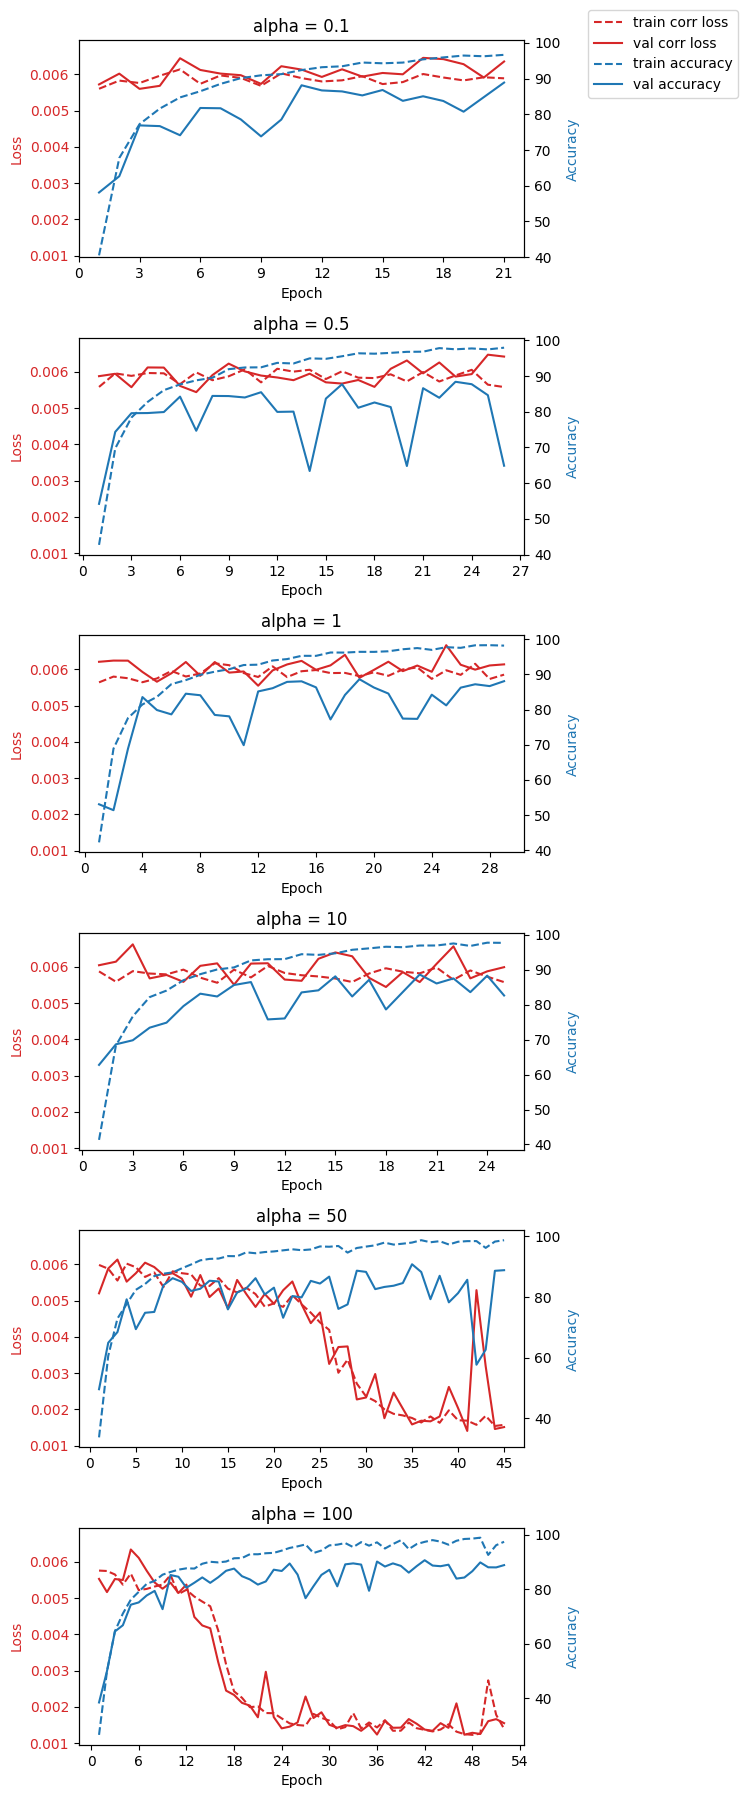

Learning rate = 0.0005


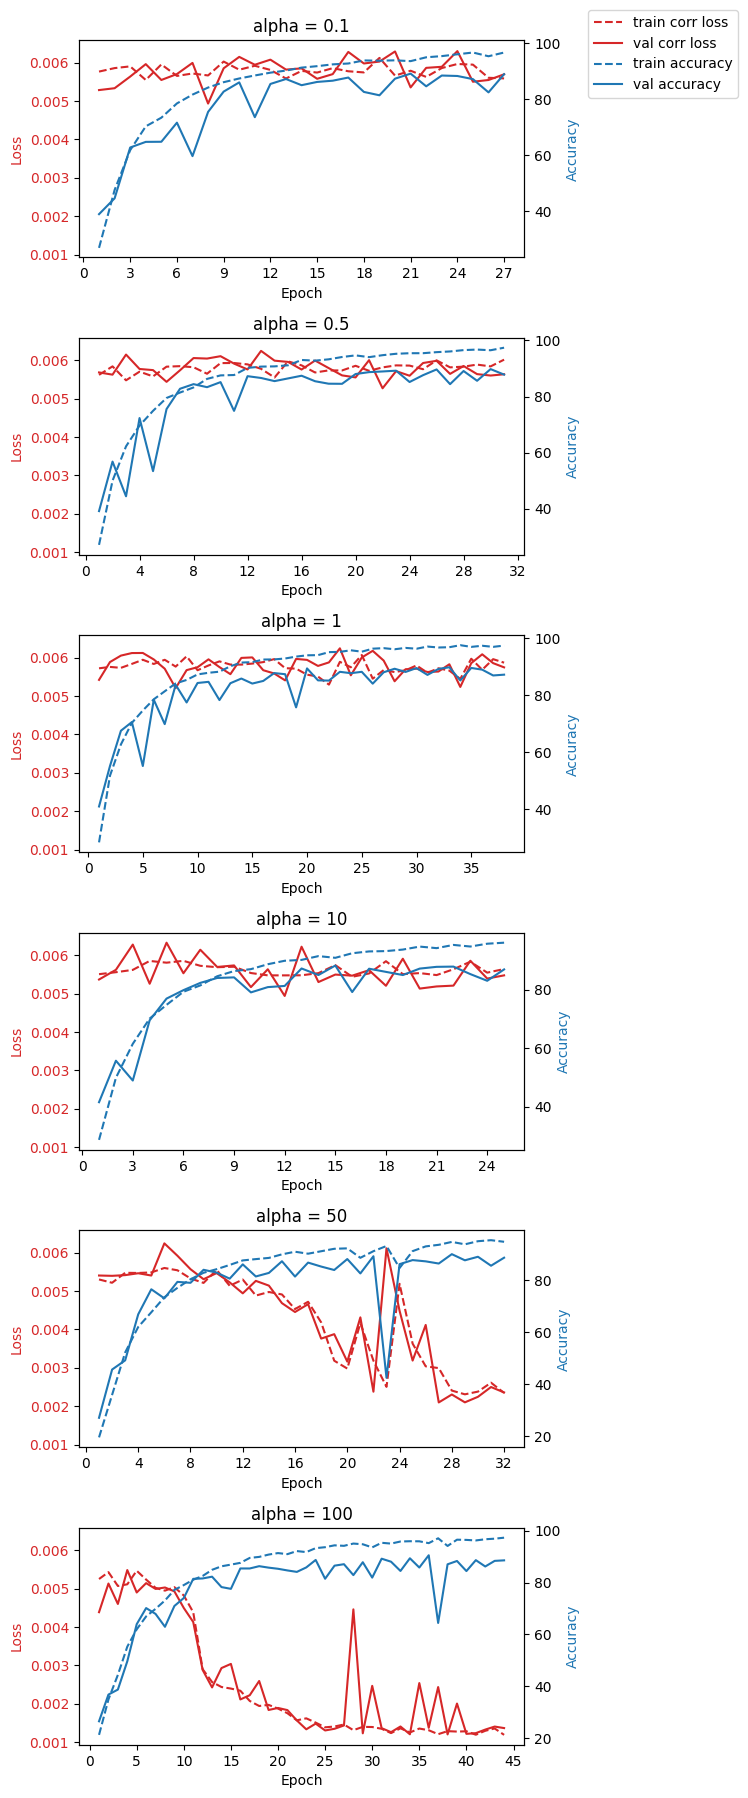

In [44]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter_corr(alphas,model32_dict[lr])

In [45]:
# free up space
gc.collect()
torch.cuda.empty_cache()

# Test

## Load data

In [46]:
# load the data
noise_test_spec_data=torch.load('data/speech_commands_processed/noise_test_spec_data.pt')
raw_test_spec_data=torch.load('data/speech_commands_processed/raw_test_spec_data.pt')

<ipython-input-46-b5b6b69b252a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_test_spec_data=torch.load('data/speech_commands_processed/noise_test_spec_data.pt')
<i

In [47]:
noise_test_dataset=MyDataset(noise_test_spec_data,word_classes,noise_classes)
raw_test_dataset=MyDataset(raw_test_spec_data,word_classes)

In [48]:
# double check shapes and size
print(f"noise len {len(noise_test_dataset)}")
print(f"raw len {len(raw_test_dataset)}")

print(f"image shape {noise_test_dataset[0][0].shape}")
print(f'labels {noise_test_dataset[0][1]}')
print(f'labels {raw_test_dataset[0][1]}')

noise len 2500
raw len 2500
image shape torch.Size([1, 227, 227])
labels (tensor(4), tensor(2))
labels 4


In [49]:
# dataloaders
noise_test_dataloader = DataLoader(noise_test_dataset, batch_size = 64, shuffle = True,generator = generator1)
raw_test_dataloader = DataLoader(raw_test_dataset, batch_size = 64, shuffle = True,generator = generator1)

In [50]:
# base test - noise
for my_string in model02_strings:
    tester(my_string,noise_test_dataloader,"tuple")
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_base_lr1e-05_20240828-123420.pth
Got 2118/2500 with accuracy 84.72


output/model_base_lr5e-05_20240828-123911.pth
Got 2139/2500 with accuracy 85.56


output/model_base_lr0.0001_20240828-124433.pth
Got 2151/2500 with accuracy 86.04


output/model_base_lr0.0005_20240828-125358.pth
Got 2238/2500 with accuracy 89.52




In [51]:
# raw
for my_string in model02_strings:
    tester(my_string,raw_test_dataloader)
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_base_lr1e-05_20240828-123420.pth
Got 1917/2500 with accuracy 76.68


output/model_base_lr5e-05_20240828-123911.pth
Got 1942/2500 with accuracy 77.68


output/model_base_lr0.0001_20240828-124433.pth
Got 2008/2500 with accuracy 80.32


output/model_base_lr0.0005_20240828-125358.pth
Got 2043/2500 with accuracy 81.72




In [52]:
# linear test - noise
for my_string in model12_strings:
    tester(my_string,noise_test_dataloader,"tuple")
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_lr1e-05_layertypenn.Linear_alpha0.1_20240828-130303.pth
Got 2097/2500 with accuracy 83.88


output/model_lr1e-05_layertypenn.Linear_alpha0.5_20240828-130900.pth
Got 2084/2500 with accuracy 83.36


output/model_lr1e-05_layertypenn.Linear_alpha1_20240828-131456.pth
Got 2088/2500 with accuracy 83.52


output/model_lr1e-05_layertypenn.Linear_alpha10_20240828-132036.pth
Got 2102/2500 with accuracy 84.08


output/model_lr1e-05_layertypenn.Linear_alpha50_20240828-133803.pth
Got 2170/2500 with accuracy 86.80


output/model_lr1e-05_layertypenn.Linear_alpha100_20240828-135517.pth
Got 2111/2500 with accuracy 84.44


output/model_lr5e-05_layertypenn.Linear_alpha0.1_20240828-140102.pth
Got 2158/2500 with accuracy 86.32


output/model_lr5e-05_layertypenn.Linear_alpha0.5_20240828-140557.pth
Got 2142/2500 with accuracy 85.68


output/model_lr5e-05_layertypenn.Linear_alpha1_20240828-141214.pth
Got 2193/2500 with accuracy 87.72


output/model_lr5e-05_layertypenn.Linear_alpha10_20240828-1416

In [53]:
# raw
for my_string in model12_strings:
    tester(my_string,raw_test_dataloader)
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_lr1e-05_layertypenn.Linear_alpha0.1_20240828-130303.pth
Got 1793/2500 with accuracy 71.72


output/model_lr1e-05_layertypenn.Linear_alpha0.5_20240828-130900.pth
Got 1836/2500 with accuracy 73.44


output/model_lr1e-05_layertypenn.Linear_alpha1_20240828-131456.pth
Got 1844/2500 with accuracy 73.76


output/model_lr1e-05_layertypenn.Linear_alpha10_20240828-132036.pth
Got 1808/2500 with accuracy 72.32


output/model_lr1e-05_layertypenn.Linear_alpha50_20240828-133803.pth
Got 1901/2500 with accuracy 76.04


output/model_lr1e-05_layertypenn.Linear_alpha100_20240828-135517.pth
Got 1790/2500 with accuracy 71.60


output/model_lr5e-05_layertypenn.Linear_alpha0.1_20240828-140102.pth
Got 1977/2500 with accuracy 79.08


output/model_lr5e-05_layertypenn.Linear_alpha0.5_20240828-140557.pth
Got 1943/2500 with accuracy 77.72


output/model_lr5e-05_layertypenn.Linear_alpha1_20240828-141214.pth
Got 1966/2500 with accuracy 78.64


output/model_lr5e-05_layertypenn.Linear_alpha10_20240828-1416

In [54]:
# conv2d test - noise
for my_string in model22_strings:
    tester(my_string,noise_test_dataloader,"tuple")
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_lr1e-05_layertypenn.Conv2d_alpha0.1_20240828-161821.pth
Got 2124/2500 with accuracy 84.96


output/model_lr1e-05_layertypenn.Conv2d_alpha0.5_20240828-162646.pth
Got 2134/2500 with accuracy 85.36


output/model_lr1e-05_layertypenn.Conv2d_alpha1_20240828-163527.pth
Got 2115/2500 with accuracy 84.60


output/model_lr1e-05_layertypenn.Conv2d_alpha10_20240828-164307.pth
Got 2092/2500 with accuracy 83.68


output/model_lr1e-05_layertypenn.Conv2d_alpha50_20240828-165228.pth
Got 2132/2500 with accuracy 85.28


output/model_lr1e-05_layertypenn.Conv2d_alpha100_20240828-170008.pth
Got 2134/2500 with accuracy 85.36


output/model_lr5e-05_layertypenn.Conv2d_alpha0.1_20240828-170529.pth
Got 2124/2500 with accuracy 84.96


output/model_lr5e-05_layertypenn.Conv2d_alpha0.5_20240828-171210.pth
Got 2174/2500 with accuracy 86.96


output/model_lr5e-05_layertypenn.Conv2d_alpha1_20240828-171832.pth
Got 2140/2500 with accuracy 85.60


output/model_lr5e-05_layertypenn.Conv2d_alpha10_20240828-1724

In [55]:
# raw
for my_string in model22_strings:
    tester(my_string,raw_test_dataloader)
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_lr1e-05_layertypenn.Conv2d_alpha0.1_20240828-161821.pth
Got 1842/2500 with accuracy 73.68


output/model_lr1e-05_layertypenn.Conv2d_alpha0.5_20240828-162646.pth
Got 1781/2500 with accuracy 71.24


output/model_lr1e-05_layertypenn.Conv2d_alpha1_20240828-163527.pth
Got 1900/2500 with accuracy 76.00


output/model_lr1e-05_layertypenn.Conv2d_alpha10_20240828-164307.pth
Got 1812/2500 with accuracy 72.48


output/model_lr1e-05_layertypenn.Conv2d_alpha50_20240828-165228.pth
Got 1809/2500 with accuracy 72.36


output/model_lr1e-05_layertypenn.Conv2d_alpha100_20240828-170008.pth
Got 1838/2500 with accuracy 73.52


output/model_lr5e-05_layertypenn.Conv2d_alpha0.1_20240828-170529.pth
Got 1930/2500 with accuracy 77.20


output/model_lr5e-05_layertypenn.Conv2d_alpha0.5_20240828-171210.pth
Got 2009/2500 with accuracy 80.36


output/model_lr5e-05_layertypenn.Conv2d_alpha1_20240828-171832.pth
Got 1916/2500 with accuracy 76.64


output/model_lr5e-05_layertypenn.Conv2d_alpha10_20240828-1724

In [56]:
# both - noise
for my_string in model32_strings:
    tester(my_string,noise_test_dataloader,"tuple")
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_lr1e-05_layertypeboth_alpha0.1_20240828-192707.pth
Got 2107/2500 with accuracy 84.28


output/model_lr1e-05_layertypeboth_alpha0.5_20240828-193555.pth
Got 2117/2500 with accuracy 84.68


output/model_lr1e-05_layertypeboth_alpha1_20240828-194424.pth
Got 2119/2500 with accuracy 84.76


output/model_lr1e-05_layertypeboth_alpha10_20240828-195107.pth
Got 2085/2500 with accuracy 83.40


output/model_lr1e-05_layertypeboth_alpha50_20240828-200049.pth
Got 2096/2500 with accuracy 83.84


output/model_lr1e-05_layertypeboth_alpha100_20240828-201117.pth
Got 2075/2500 with accuracy 83.00


output/model_lr5e-05_layertypeboth_alpha0.1_20240828-201945.pth
Got 2203/2500 with accuracy 88.12


output/model_lr5e-05_layertypeboth_alpha0.5_20240828-202713.pth
Got 2166/2500 with accuracy 86.64


output/model_lr5e-05_layertypeboth_alpha1_20240828-203258.pth
Got 2136/2500 with accuracy 85.44


output/model_lr5e-05_layertypeboth_alpha10_20240828-204006.pth
Got 2150/2500 with accuracy 86.00


output/

In [57]:
# raw
for my_string in model32_strings:
    tester(my_string,raw_test_dataloader)
    print()

<ipython-input-7-87140b89c5cb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_string))


output/model_lr1e-05_layertypeboth_alpha0.1_20240828-192707.pth
Got 1822/2500 with accuracy 72.88


output/model_lr1e-05_layertypeboth_alpha0.5_20240828-193555.pth
Got 1828/2500 with accuracy 73.12


output/model_lr1e-05_layertypeboth_alpha1_20240828-194424.pth
Got 1792/2500 with accuracy 71.68


output/model_lr1e-05_layertypeboth_alpha10_20240828-195107.pth
Got 1783/2500 with accuracy 71.32


output/model_lr1e-05_layertypeboth_alpha50_20240828-200049.pth
Got 1880/2500 with accuracy 75.20


output/model_lr1e-05_layertypeboth_alpha100_20240828-201117.pth
Got 1761/2500 with accuracy 70.44


output/model_lr5e-05_layertypeboth_alpha0.1_20240828-201945.pth
Got 1993/2500 with accuracy 79.72


output/model_lr5e-05_layertypeboth_alpha0.5_20240828-202713.pth
Got 2014/2500 with accuracy 80.56


output/model_lr5e-05_layertypeboth_alpha1_20240828-203258.pth
Got 1971/2500 with accuracy 78.84


output/model_lr5e-05_layertypeboth_alpha10_20240828-204006.pth
Got 1983/2500 with accuracy 79.32


output/